## Importing the Dependencies

In [41]:
import collections
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data Preparation and Exploration

In [42]:
train = pd.read_csv("https://github.com/DSstore/Loan/raw/main/train.csv")
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [43]:
test = pd.read_csv("https://github.com/DSstore/Loan/raw/main/test.csv")
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [44]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

13 columns

In [45]:
test.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

12 columns

From this, we can see the train dataset contains 12 independent variables and 1 target variable (Loan_Status)

3 formats of the datatype used
1. object  = String,Boolean Variables (Categorical , Nominal/Ordinal)
2. int64 = Integer Variables (Numerical , Discrete)
3. float64 = Float Variables (Numerical, Continuous)

In [46]:
train.shape

(614, 13)

train dataset has 614 rows and 13 columns

In [47]:
test.shape

(367, 12)

test dataset has 367 rows and 12 columns

In [48]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [49]:
#Checking if theres any with same load_id in both train and test
train_id = list(train['Loan_ID'])
test_id = list(test['Loan_ID'])

if collections.Counter(train_id) == collections.Counter(test_id):
    print("There are records with similar ID")
else:
    print("Different sets of load ids are in both of the datasets")

Different sets of load ids are in both of the datasets


In [50]:
#Checking for duplicates of Loan_ID in train dataset
duplicate_check_train = train.shape[0] - train.Loan_ID.nunique()

print(f'There are {duplicate_check_train} duplicates for load id in the train dataset')

There are 0 duplicates for load id in the train dataset


In [51]:
#Checking for duplicates of Loan_ID in test dataset
duplicate_check_test = test.shape[0] - test.Loan_ID.nunique()

print(f'There are {duplicate_check_test} duplicates for load id in the test dataset')

There are 0 duplicates for load id in the test dataset


In [52]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [53]:
cols = train.columns
for col in cols:
    print(f"{col}:\n{train[col].value_counts()}\n","-"*50)


Loan_ID:
LP001356    1
LP001800    1
LP002832    1
LP002862    1
LP001963    1
           ..
LP001041    1
LP002606    1
LP002618    1
LP001489    1
LP001267    1
Name: Loan_ID, Length: 614, dtype: int64
 --------------------------------------------------
Gender:
Male      489
Female    112
Name: Gender, dtype: int64
 --------------------------------------------------
Married:
Yes    398
No     213
Name: Married, dtype: int64
 --------------------------------------------------
Dependents:
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
 --------------------------------------------------
Education:
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
 --------------------------------------------------
Self_Employed:
No     500
Yes     82
Name: Self_Employed, dtype: int64
 --------------------------------------------------
ApplicantIncome:
2500    9
6000    6
2600    6
4583    6
4166    5
       ..
5503    1
3450    1
2425    1
2423    1
4095    1


Find out the counts for each variables.

Y    422
N    192
Name: Loan_Status, dtype: int64

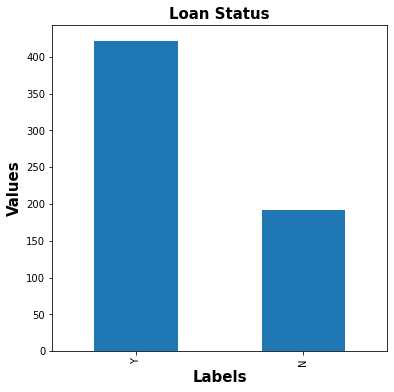

In [54]:
train['Loan_Status'].value_counts().plot.bar(figsize=(6,6))
plt.title('Loan Status', fontweight='bold', size=15)
plt.ylabel('Values', fontweight='bold', size=15)
plt.xlabel('Labels', fontweight='bold', size=15)
train['Loan_Status'].value_counts()

This shows that Loan Status has 422 'Y' and 192 'N'

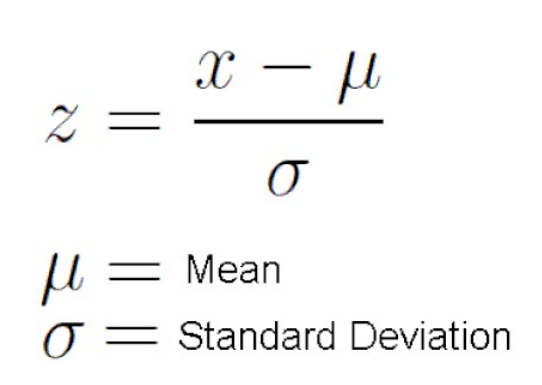

In [55]:
Image("https://raw.githubusercontent.com/DSstore/Loan/main/image/normalize.png")

Why data normalization?
transform a data set so that all of its variations fall between zero and one

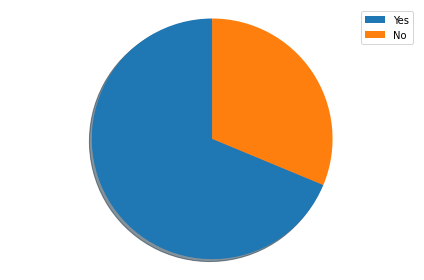

Y    68.729642
N    31.270358
Name: Loan_Status, dtype: float64


In [56]:
normalizeLoan = train['Loan_Status'].value_counts(normalize=True)*100
labels = ['Yes', 'No']
patches, texts = plt.pie(normalizeLoan, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()
print(normalizeLoan)

From this, we can see that the 'Y' has 68.73% while the 'N' has 31.27%
So the loan of 422(around 69%) people out of 614 were approved

Visualize each variable separately according to the type of variable

In [57]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

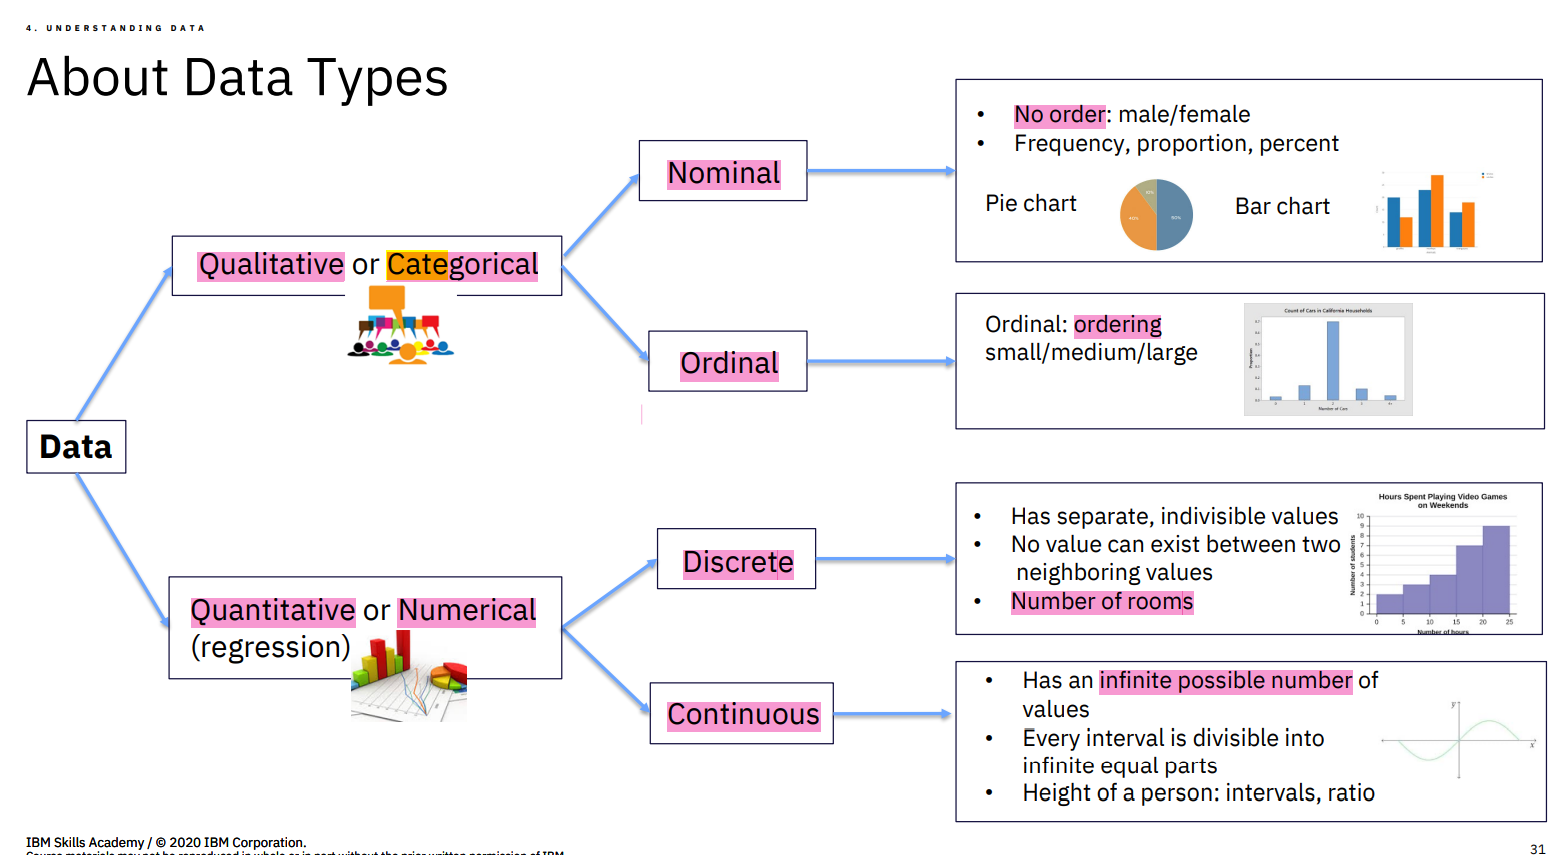

In [58]:
Image("https://raw.githubusercontent.com/DSstore/Loan/main/image/datatypes.png")

From these, we can visualize each column based on the data type properties

Nominal Features
- Gender
- Married
- Self-Employed
- Credit_History
- Loan_Status

Ordinal Features
- Dependents
- Property_Area
- Education

Numerical features
- ApplicantIncome
- CoapplicantIncome
- LoanAmount
- Loan_Amount_Term

## Data Representation & Transformation

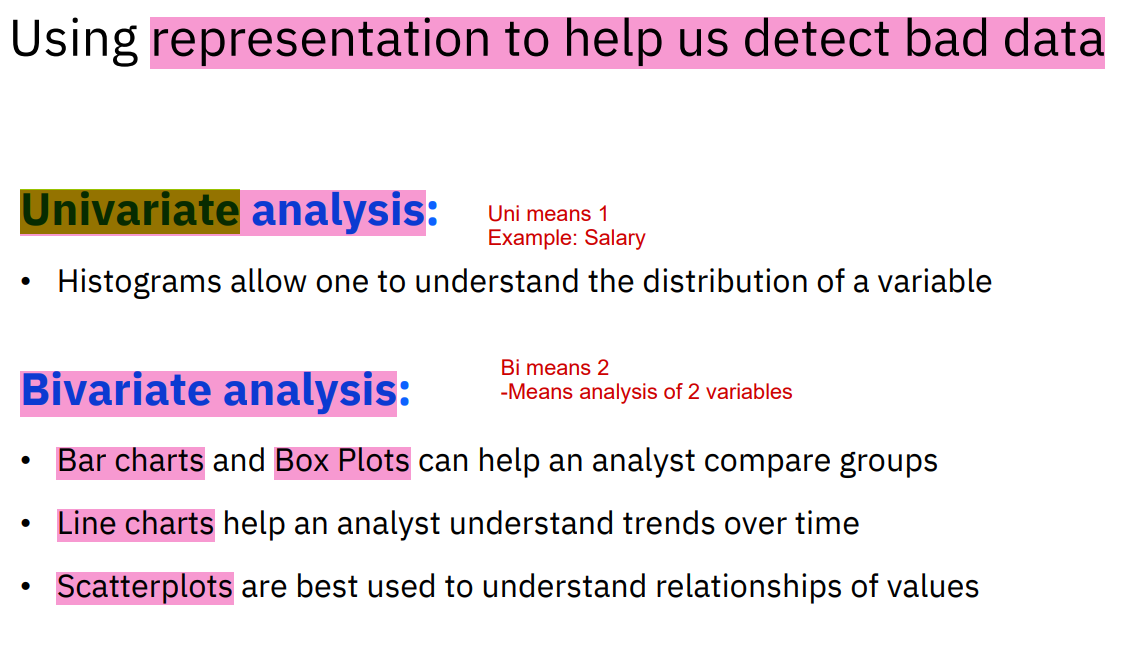

In [59]:
Image("https://raw.githubusercontent.com/DSstore/Loan/main/image/uni_bi_analysis.png")

## Univariate Analysis

## 1. Independent Variable (Categorical)

Text(0.5, 0, 'Labels')

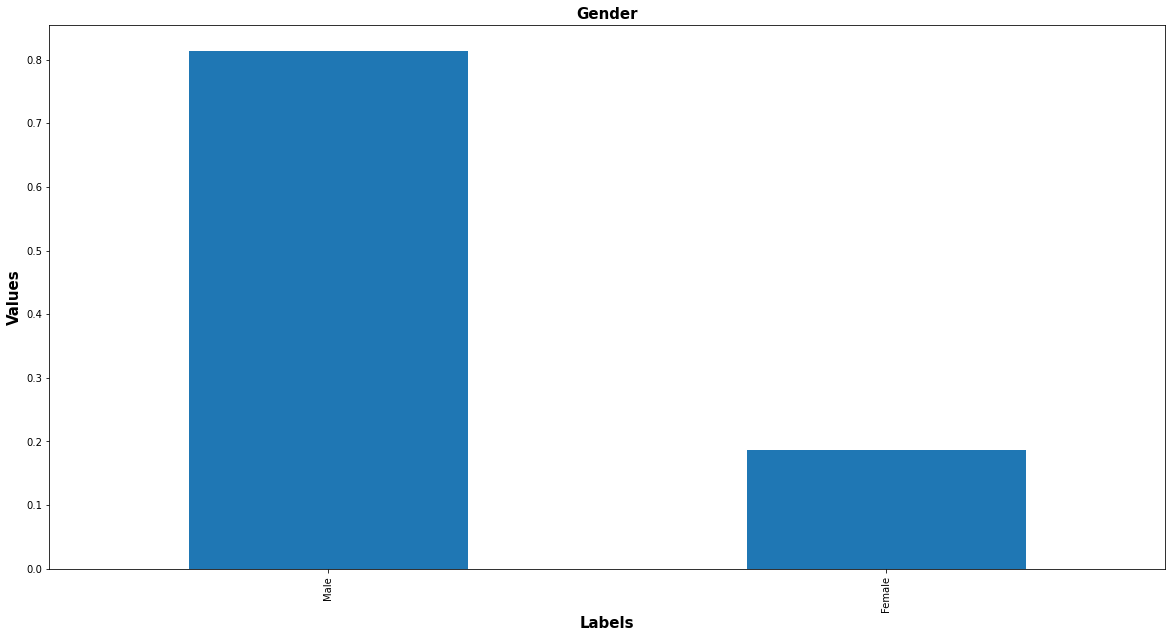

In [60]:
train['Gender'].value_counts(normalize=True).plot.bar(figsize=(20,10))
plt.title('Gender', fontweight='bold', size=15)
plt.ylabel('Values', fontweight='bold', size=15)
plt.xlabel('Labels', fontweight='bold', size=15)

Estimation: 80% of the applicants in the dataset are male, 20% female

Text(0.5, 0, 'Labels')

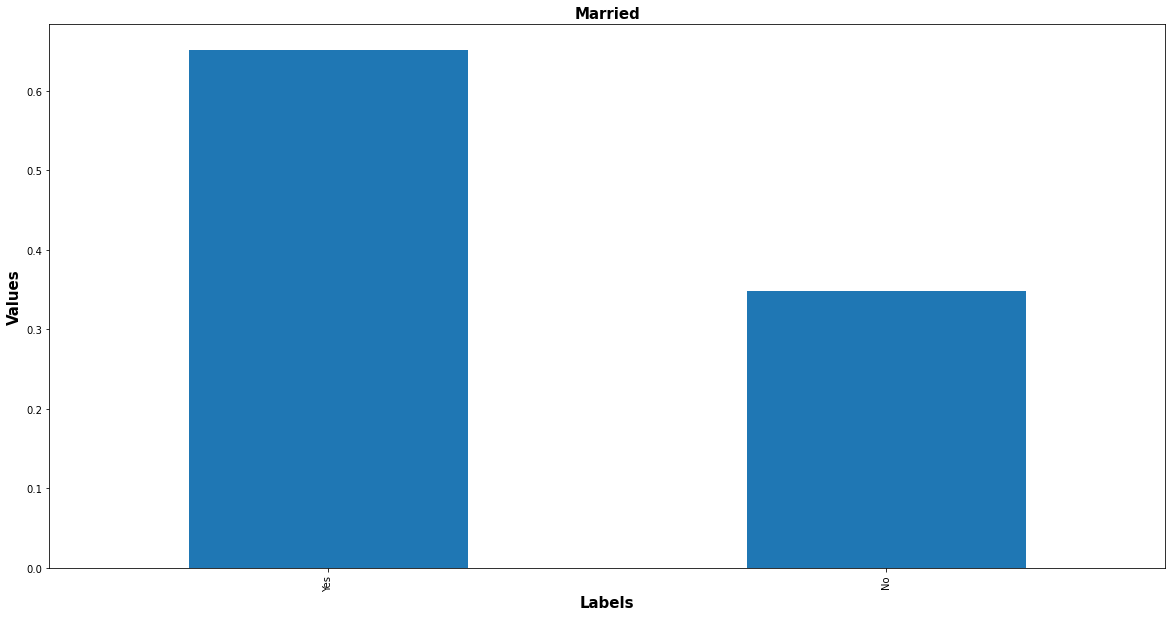

In [61]:
train['Married'].value_counts(normalize=True).plot.bar(figsize=(20,10))
plt.title('Married', fontweight='bold', size=15)
plt.ylabel('Values', fontweight='bold', size=15)
plt.xlabel('Labels', fontweight='bold', size=15)

Estimation: 65% married, 35% not married

Text(0.5, 0, 'Labels')

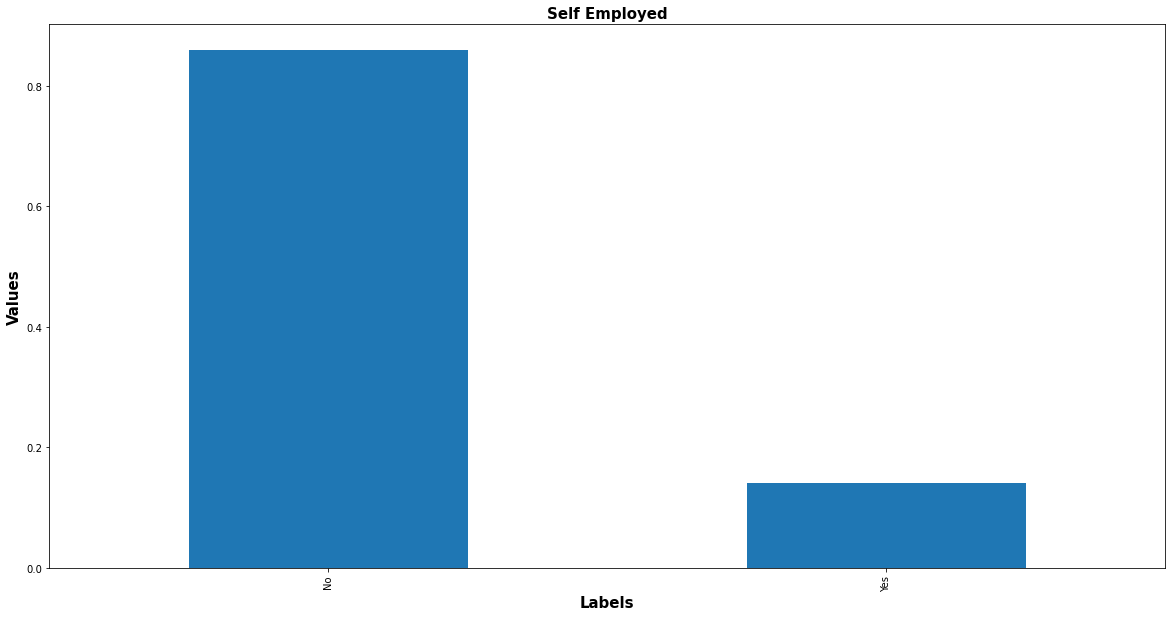

In [62]:
train['Self_Employed'].value_counts(normalize=True).plot.bar(figsize=(20,10))
plt.title('Self Employed', fontweight='bold', size=15)
plt.ylabel('Values', fontweight='bold', size=15)
plt.xlabel('Labels', fontweight='bold', size=15)

Estimation: 15% of applicants are self-employed, 85% are not.

Text(0.5, 0, 'Labels')

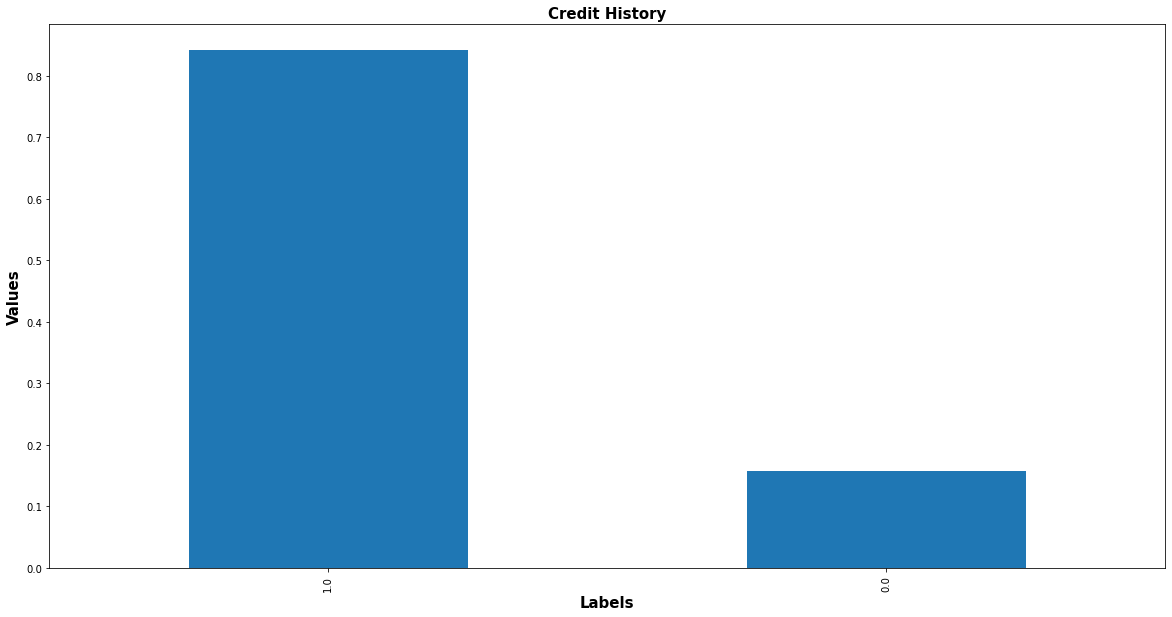

In [63]:
train['Credit_History'].value_counts(normalize=True).plot.bar(figsize=(20,10))
plt.title('Credit History', fontweight='bold', size=15)
plt.ylabel('Values', fontweight='bold', size=15)
plt.xlabel('Labels', fontweight='bold', size=15)

Estimation: 85% of the applicants have repaid their debts, 15% have not repaid

## Summary of the Idependent Variable (Categorical)
- 80% of applicants in the dataset are male
- Around 65% of the applicants in the dataset are married
- Around 15% of the applicants in the dataset are self-employed
- Around 85% of the applicants have repaid their debts

## 2.Independent Variable (Ordinal)

Text(0.5, 0, 'Labels')

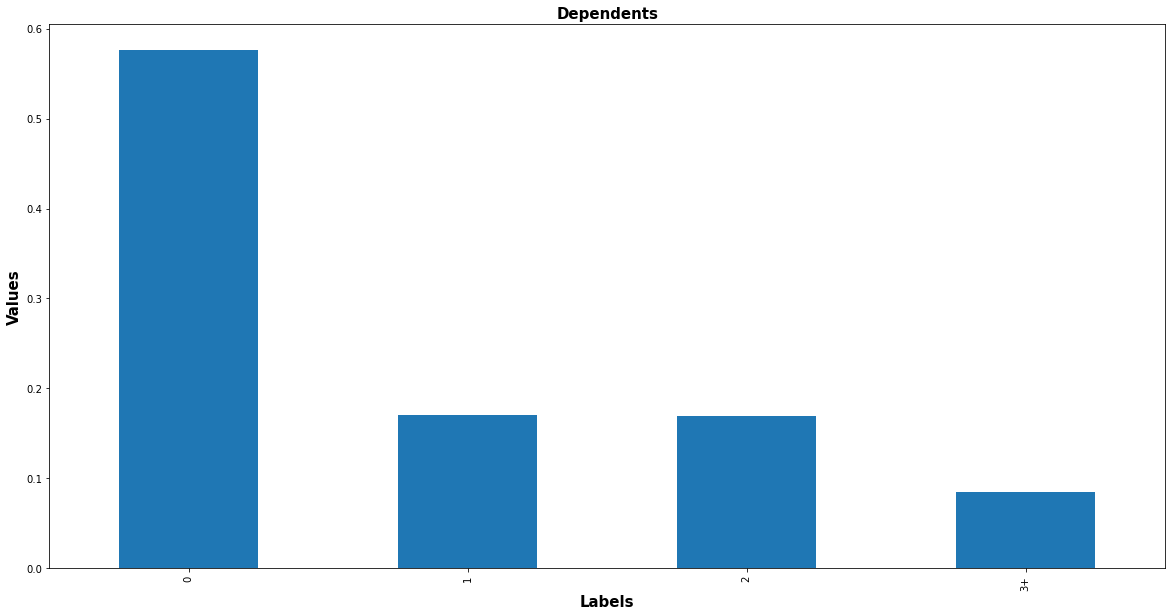

In [64]:
train['Dependents'].value_counts(normalize=True).plot.bar(figsize=(20,10))
plt.title('Dependents', fontweight='bold', size=15)
plt.ylabel('Values', fontweight='bold', size=15)
plt.xlabel('Labels', fontweight='bold', size=15)

Estimation: More than 58% of the applicants does not have dependents

Text(0.5, 0, 'Labels')

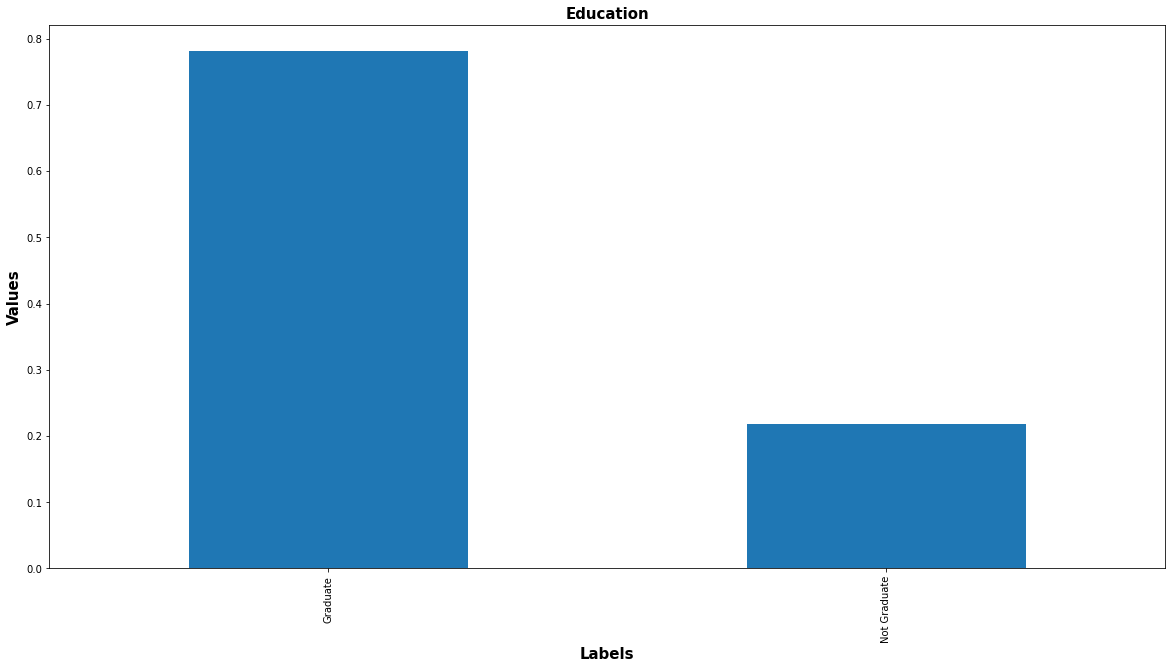

In [65]:
train['Education'].value_counts(normalize=True).plot.bar(figsize=(20,10))
plt.title('Education', fontweight='bold', size=15)
plt.ylabel('Values', fontweight='bold', size=15)
plt.xlabel('Labels', fontweight='bold', size=15)

Estimation: 80% of the applicants are Graduate, 20% are not

Text(0.5, 0, 'Labels')

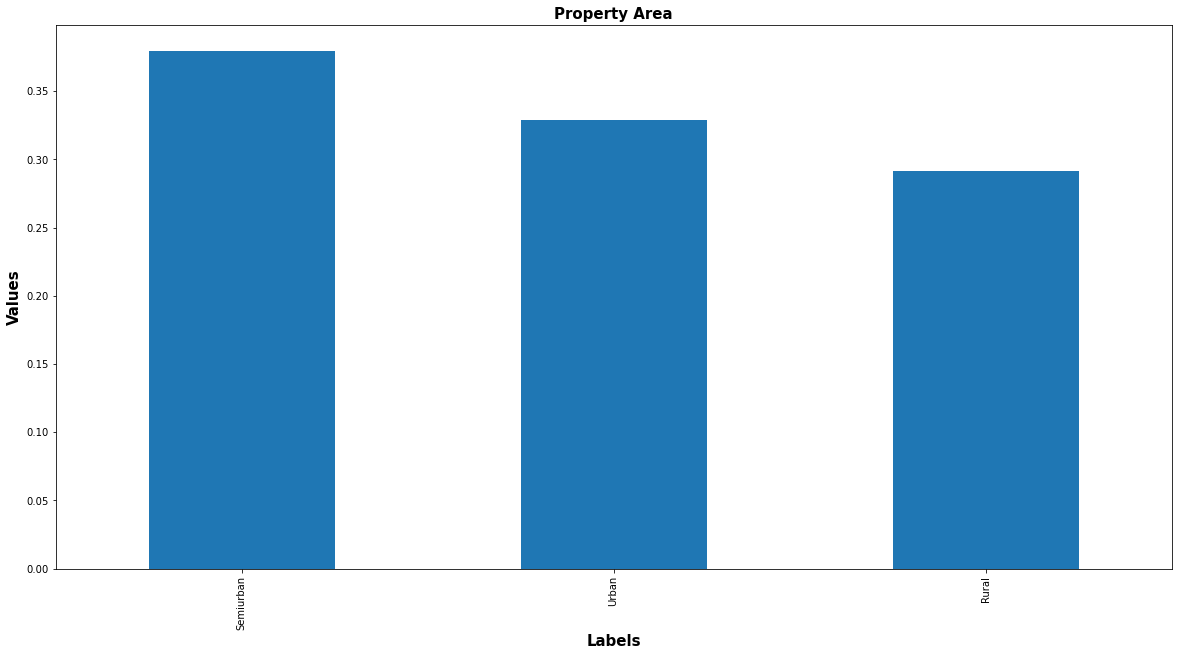

In [66]:
train['Property_Area'].value_counts(normalize=True).plot.bar(figsize=(20,10))
plt.title('Property Area', fontweight='bold', size=15)
plt.ylabel('Values', fontweight='bold', size=15)
plt.xlabel('Labels', fontweight='bold', size=15)

Estimation: More than 35% of the applicants are from Semiurban Area, more than 30% are from Urban area while more than 25% are from Rural Area

## Summary of Independent Variable (Ordinal)
- Most of the applicants don't have any dependents
- Around 80% of the applicants are Graduate
- Most of the applicants are from Semiurban area

## 3.Independent Variable (Numerical)

Applicant's Income

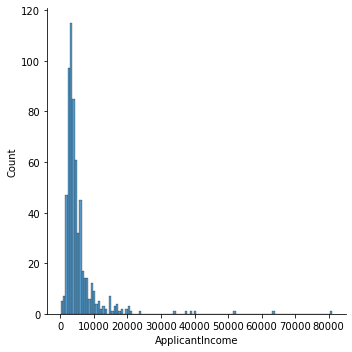

In [67]:
sns.displot(train['ApplicantIncome'])
plt.show()

From this graph, it can interpreted that most of data in the distribution of applicant income are towards to the left side of the graph. Assumed that it is not currently normally distributed at the moment.
We will try to make it normal later as algorithms work better if the data is normally distributed

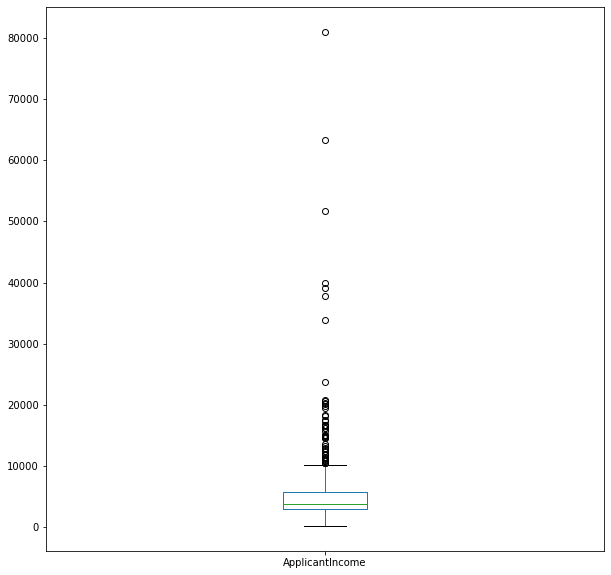

In [68]:
train['ApplicantIncome'].plot.box(figsize=(10,10))
plt.show()

The boxplot confirms the presence of a lot of outliers (extreme values).
This can be attributed to the income disparity in the society.
Further analysis needed as we maybe looking at applicants with different education levels.

Text(0.5, 0.98, '')

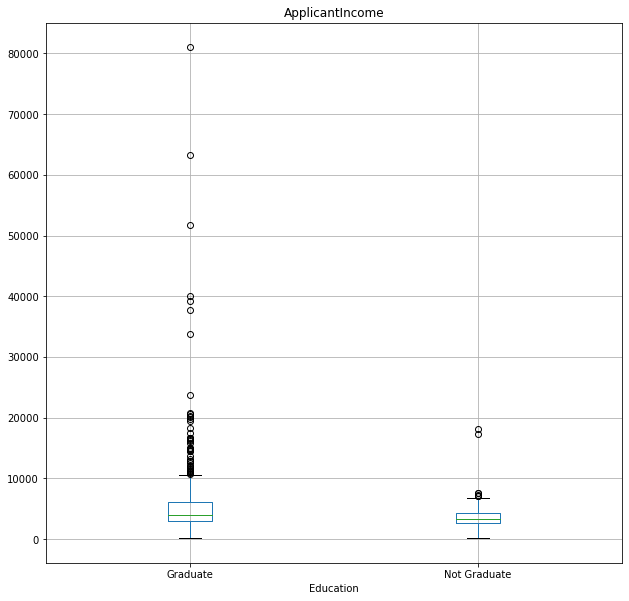

In [69]:
train.boxplot(column='ApplicantIncome', by='Education', figsize=(10,10))
plt.suptitle("")

We can see that there are a higher number of graduates with very high income, and we can identify them as outliers

Co-applicant's Income

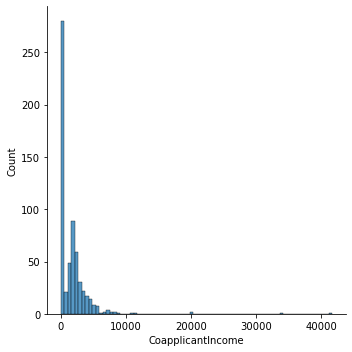

In [70]:
sns.displot(train['CoapplicantIncome'])
plt.show()

From this graph, we can see a similar distribution as that of the applicant's income.
Majority of the co-applicants income range from 0 to 5000.

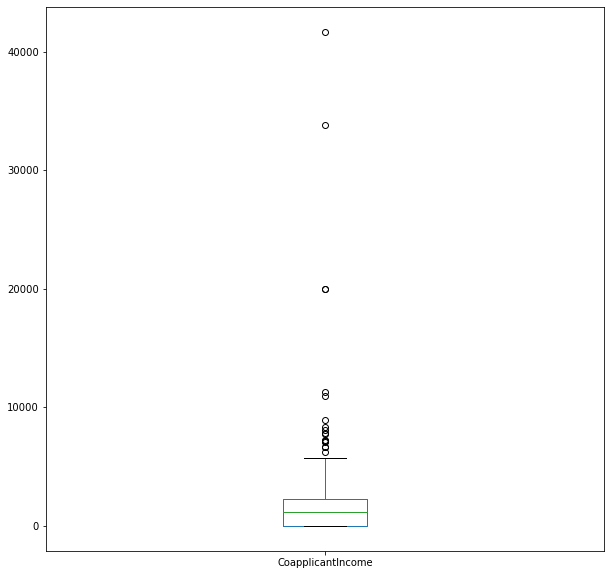

In [71]:
train['CoapplicantIncome'].plot.box(figsize=(10,10))
plt.show()

We can also see a lot of outliers in the co-applicant's income and it is not normally distributed

Loan Amount

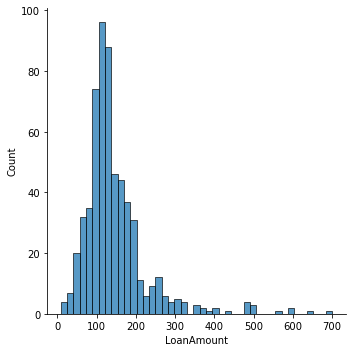

In [72]:
sns.displot(train['LoanAmount'])
plt.show()

The distribution is fairly normal comparing with the two other previous numerical variables

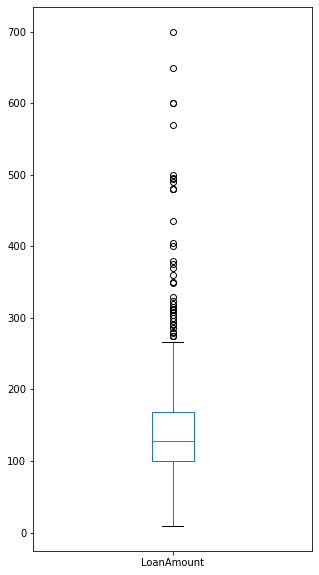

In [73]:
train['LoanAmount'].plot.box(figsize=(5,10))
plt.show()

We can still see a lot of outliers in this variable as well.

## Data Cleansing

## Removing Unique Identifier

In [74]:
train['Loan_ID'].describe()

count          614
unique         614
top       LP001356
freq             1
Name: Loan_ID, dtype: object

In [75]:
test['Loan_ID'].describe()

count          367
unique         367
top       LP002962
freq             1
Name: Loan_ID, dtype: object

In [76]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [77]:
test['Loan_ID'].describe()

count          367
unique         367
top       LP002962
freq             1
Name: Loan_ID, dtype: object

In [78]:
test.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,367.000000,367.000000,362.000000,361.000000,338.000000
mean,4805.599455,1569.577657,136.132597,342.537396,0.825444
std,4910.685399,2334.232099,61.366652,65.156643,0.380150
min,0.000000,0.000000,28.000000,6.000000,0.000000
25%,2864.000000,0.000000,100.250000,360.000000,1.000000
50%,3786.000000,1025.000000,125.000000,360.000000,1.000000
75%,5060.000000,2430.500000,158.000000,360.000000,1.000000
max,72529.000000,24000.000000,550.000000,480.000000,1.000000


We drop Load_ID as it is unique and it has no impact on the target variable Loan_Status

In [79]:
train=train.drop('Loan_ID',axis=1)
test=test.drop('Loan_ID',axis=1)

## Impute Missing Value

In [80]:
train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

There are missing values in Gender, Married, Dependents, Self_Employed, LoanAmount, Loan_Amount_Term and Credit_History features

Numerical variables: imputation using mean or median (LoanAmount, Loan_Amount_Term)

Categorical(Nominal) variables: imputation using mode (Gender, Married, Dependents, Credit_History, Self_Employed)

In [81]:
train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
train['Married'].fillna(train['Married'].mode()[0], inplace=True)
train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
train.isnull().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [82]:
train['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

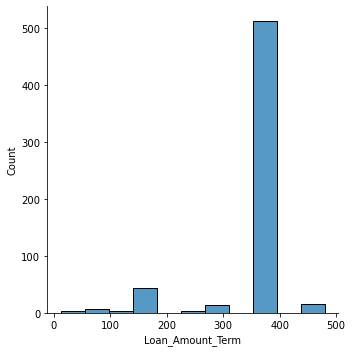

In [83]:
sns.displot(train.Loan_Amount_Term)

In [84]:
train['Loan_Amount_Term'].mode()[0]

360.0

In [85]:
train['Loan_Amount_Term'].median()

360.0

We can't use mean as the distribution is too large

We will use mode or median for Loan_Amount_Term since both returns the same results

In [86]:
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)

In [87]:
train.isnull().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

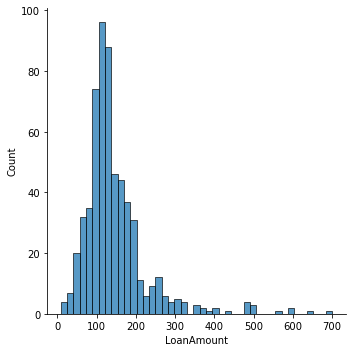

In [88]:
sns.displot(train.LoanAmount)

As for LoanAmount, it is a numerical variable so we will be using mean or median to impute the missing values.

However, loan amount has significant amount of outliers

Mean approach will be highly affected by the presence of these outliers. So we will be using median in this situation.

In [89]:
train['LoanAmount'].median()

128.0

In [90]:
train['LoanAmount'].fillna(train['LoanAmount'].median(),inplace=True)
train.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

We will do the same to test dataset

In [91]:
test.isnull().sum()

Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [92]:
test['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
test['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
test['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
test['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)
test['LoanAmount'].fillna(train['LoanAmount'].median(),inplace=True)
test.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

## Outlier Treatment

<AxesSubplot:>

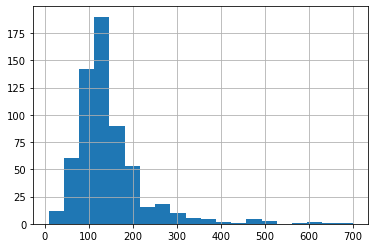

In [93]:
train['LoanAmount'].hist(bins=20)

As we can see here, due to these outliers, bulk of the data is at the left and right tail is longer. This is called right skewness. One way to remove skewness is by doing log transformation. As we do do the log transformation, it does not affect the smaller values much but reduces the larger values. So we get a distribution similar to normal distribution.

<AxesSubplot:>

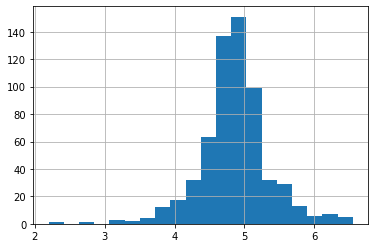

In [94]:
train['LoanAmount_log']=np.log(train['LoanAmount'])
train['LoanAmount_log'].hist(bins=20)

Now the distributions looks much closer to normal and the effect of extreme values has been significantly subsided. Now we do the same to the test dataframe.

<AxesSubplot:>

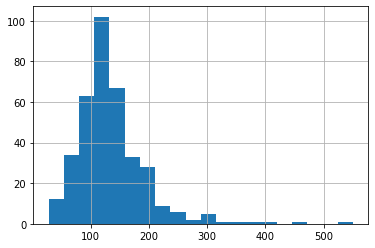

In [95]:
test['LoanAmount'].hist(bins=20)

<AxesSubplot:>

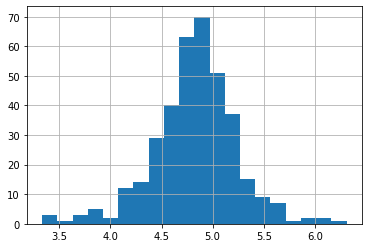

In [96]:
test['LoanAmount_log']=np.log(test['LoanAmount'])
test['LoanAmount_log'].hist(bins=20)

## Bivariate Analysis

Bivariate analysis is finding some kind of empirical relationship between two variables. Specifically the dependent vs independent Variables

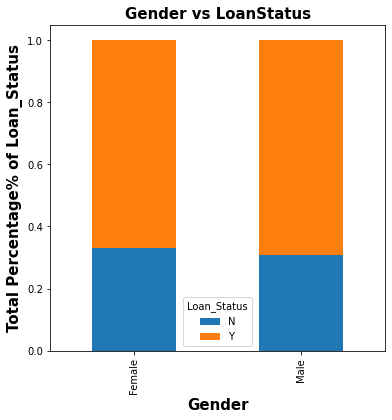

In [97]:
Gender = pd.crosstab(train['Gender'],train['Loan_Status'])
Gender.div(Gender.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(6,6))
plt.title('Gender vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('Total Percentage% of Loan_Status', fontweight='bold', size=15)
plt.xlabel('Gender', fontweight='bold', size=15)
plt.show()

There is not a substantial difference between male and female approval rates.

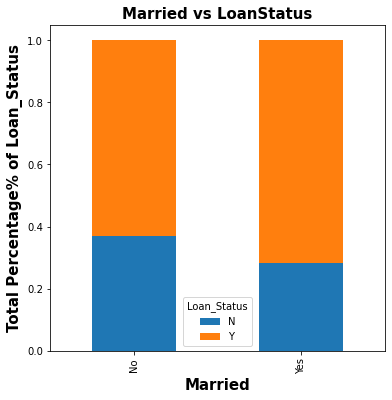

In [98]:
Married = pd.crosstab(train['Married'], train['Loan_Status'])
Married.div(Married.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(6,6))
plt.title('Married vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('Total Percentage% of Loan_Status', fontweight='bold', size=15)
plt.xlabel('Married', fontweight='bold', size=15)
plt.show()

Married Applicants have a slightly higher chances of loan approval

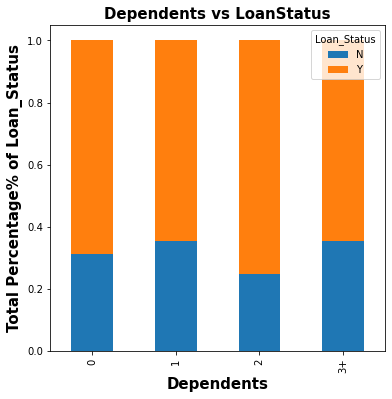

In [99]:
Dependents = pd.crosstab(train['Dependents'], train['Loan_Status'])
Dependents.div(Dependents.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(6,6))
plt.title('Dependents vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('Total Percentage% of Loan_Status', fontweight='bold', size=15)
plt.xlabel('Dependents', fontweight='bold', size=15)
plt.show()

Distribution of the applicants is almost similar across all the two categories of Loan_Status. Thus does not correlate well.

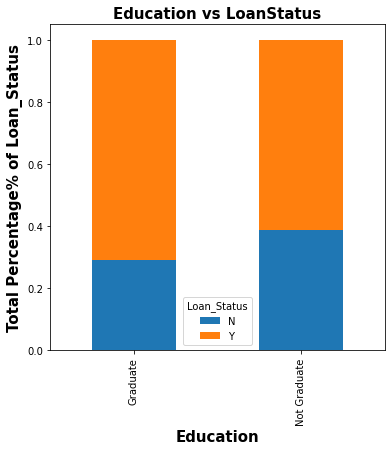

In [100]:
Education = pd.crosstab(train['Education'], train['Loan_Status'])
Education.div(Education.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(6,6))
plt.title('Education vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('Total Percentage% of Loan_Status', fontweight='bold', size=15)
plt.xlabel('Education', fontweight='bold', size=15)
plt.show()

Graduates have higher chance of loan approval compared to non-graduates

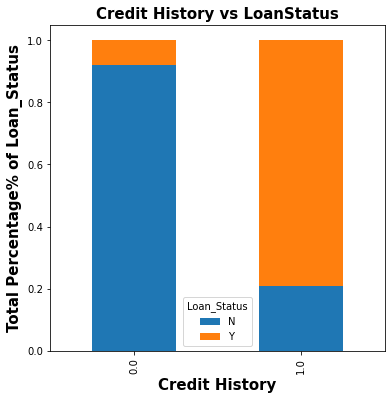

In [101]:
Credit_History = pd.crosstab(train['Credit_History'], train['Loan_Status'])
Credit_History.div(Credit_History.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(6,6))
plt.title('Credit History vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('Total Percentage% of Loan_Status', fontweight='bold', size=15)
plt.xlabel('Credit History', fontweight='bold', size=15)
plt.show()

It seems that people with credit history of 1 are more likely to get their loans approved

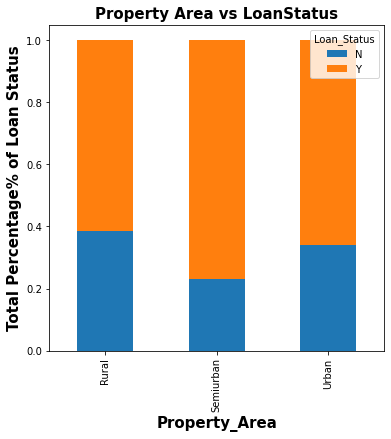

In [102]:
Property_Area = pd.crosstab(train['Property_Area'], train['Loan_Status'])
Property_Area.div(Property_Area.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(6,6))
plt.title('Property Area vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('Total Percentage% of Loan Status', fontweight='bold', size=15)
plt.xlabel('Property_Area', fontweight='bold', size=15)
plt.show()

The proportion of loans getting approved in Semi-Urban area is higher than those living in Rural or Urban area.

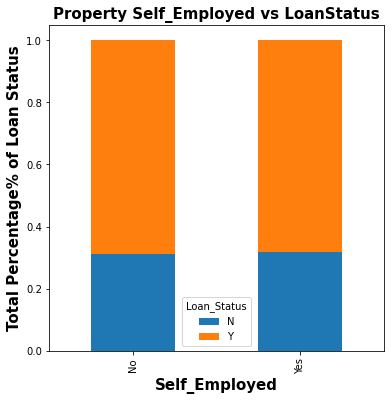

In [103]:
Self_Employed=pd.crosstab(train['Self_Employed'],train['Loan_Status'])
Self_Employed.div(Self_Employed.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(6,6))
plt.title('Property Self_Employed vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('Total Percentage% of Loan Status', fontweight='bold', size=15)
plt.xlabel('Self_Employed', fontweight='bold', size=15)
plt.show()

There is nothing significant we can infer from Self_Employed vs Loan_Status plot

## Numerical Independent Variable vs Target Variable

We try to find the mean income of people for which loan has been approved vs the mean income of people for which loan has not been approved

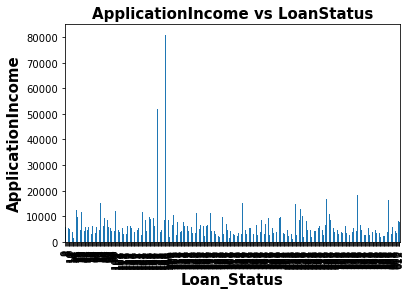

In [104]:
train.groupby('Loan_Status')['ApplicantIncome'].plot.bar()
plt.title('ApplicationIncome vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('ApplicationIncome', fontweight='bold', size=15)
plt.xlabel('Loan_Status', fontweight='bold', size=15)
plt.show()

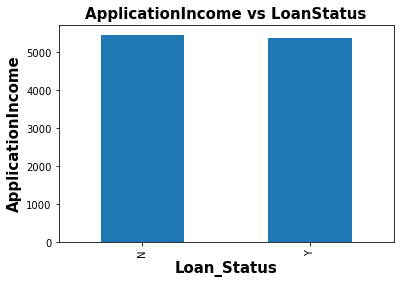

In [105]:
train.groupby('Loan_Status')['ApplicantIncome'].mean().plot.bar()
plt.title('ApplicationIncome vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('ApplicationIncome', fontweight='bold', size=15)
plt.xlabel('Loan_Status', fontweight='bold', size=15)
plt.show()

However, we don't see any changes in the mean income. Therefore we will make bins for the applicant income variable based on the values in it to analyze it.

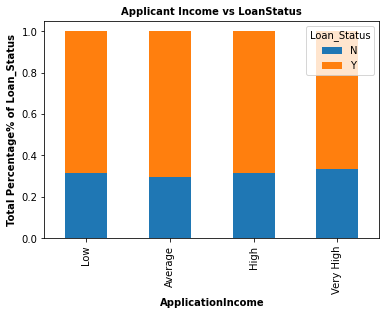

In [106]:
bins=[0,2500,4000,6000,81000]
group=['Low','Average','High','Very High']
train['Income_bin']=pd.cut(train['ApplicantIncome'], bins, labels=group)
Income_bin=pd.crosstab(train['Income_bin'],train['Loan_Status'])
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.title('Applicant Income vs LoanStatus', fontweight='bold', size=10)
plt.ylabel('Total Percentage% of Loan_Status', fontweight='bold', size=10)
plt.xlabel('ApplicationIncome', fontweight='bold', size=10)
plt.show()

We can see that Applicant Income does not affect the chances of loan approval which contradicts our hypothesis in which we assumed if the applicant income is high, the chances of loan approval will also be high.

In [107]:
train['CoapplicantIncome'].describe()

count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64

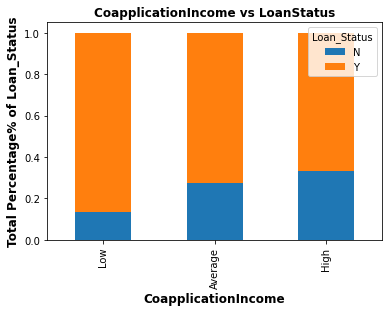

In [108]:
bins=[0,1000,3000,42000]
group=['Low','Average','High']
train['Coapplicant_Income_bin']=pd.cut(train['CoapplicantIncome'],bins,labels=group)
Coapplicant_Income_bin=pd.crosstab(train['Coapplicant_Income_bin'],train['Loan_Status'])
Coapplicant_Income_bin.div(Coapplicant_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.title('CoapplicationIncome vs LoanStatus', fontweight='bold', size=12)
plt.ylabel('Total Percentage% of Loan_Status', fontweight='bold', size=12)
plt.xlabel('CoapplicationIncome', fontweight='bold', size=12)
plt.show()

This can be inferred as if the Co-applicant's income is low, the chances for loan approval is higher which is not right.
The possible reason behind this is that some of the applicants do not have co-applicant hence the income of the co-applicant is displayed as zero in the dataset. Therefore the loan approval is not dependent on it.

In [109]:
train['Coapplicant_Income_bin'].isnull().sum()

273

For this, we will introduce a new column by summing up both applicant income and co-applicant income in order to visualize the combined effect on the loan approval.

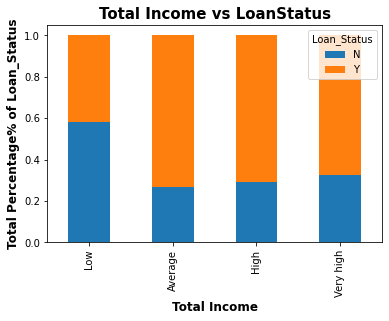

In [110]:
train['Total_Income']=train['ApplicantIncome']+train['CoapplicantIncome']
bins=[0,2500,4000,6000,81000]
group=['Low','Average','High','Very high']
train['Total_Income_bin']=pd.cut(train['Total_Income'],bins,labels=group)
Total_Income_bin=pd.crosstab(train['Total_Income_bin'],train['Loan_Status'])
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.title('Total Income vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('Total Percentage% of Loan_Status', fontweight='bold', size=12)
plt.xlabel('Total Income', fontweight='bold', size=12)
plt.show()

From this, we can see that the Proportion of loans getting approved for applicants having low Total_Income is very much lesser than the rest of its categories (Average,High,Very High)

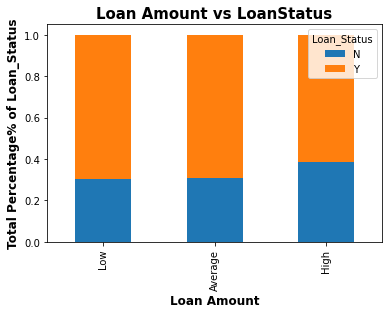

In [111]:
bins=[0,100,250,700]
group=['Low','Average','High']
train['LoanAmount_bin']=pd.cut(train['LoanAmount'],bins,labels=group)
LoanAmount_bin=pd.crosstab(train['LoanAmount_bin'],train['Loan_Status'])
LoanAmount_bin.div(LoanAmount_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.title('Loan Amount vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('Total Percentage% of Loan_Status', fontweight='bold', size=12)
plt.xlabel('Loan Amount', fontweight='bold', size=12)
plt.show()

In [112]:
train['LoanAmount'].describe()

count    614.000000
mean     145.752443
std       84.107233
min        9.000000
25%      100.250000
50%      128.000000
75%      164.750000
max      700.000000
Name: LoanAmount, dtype: float64

From this, we can see that the proportion for both 'Low' and 'Average' of the approved loan is higher compared to 'High' loan amount. This supports our hypothesis which the chances of loan approval will be higher if loan amount is lower.


In [113]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log,Income_bin,Coapplicant_Income_bin,Total_Income,Total_Income_bin,LoanAmount_bin
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y,4.852030,High,NaN,5849.0,High,Average
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,4.852030,High,Average,6091.0,Very high,Average
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,4.189655,Average,NaN,3000.0,Average,Low
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4.787492,Average,Average,4941.0,High,Average
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,4.948760,High,NaN,6000.0,High,Average


We have to drop the bin that were created for the visualization

In [114]:
train=train.drop(['Income_bin','Coapplicant_Income_bin','LoanAmount_bin','Total_Income_bin','Total_Income'], axis=1)

In [115]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y,4.852030
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,4.852030
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,4.189655
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4.787492
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,4.948760


We need to change the value '3+' in Dependents column to 3 in order to make Dependents a numerical variable for visualization

In [116]:
train['Dependents'].replace('3+', 3, inplace=True)
test['Dependents'].replace('3+', 3, inplace=True)

In [117]:
train['Dependents'].value_counts()

0    360
1    102
2    101
3     51
Name: Dependents, dtype: int64

We also need to change the value in Loan_Status N with 0 and Y with 1 for visualization

In [118]:
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [119]:
train['Loan_Status'].replace('Y', 1, inplace=True)
train['Loan_Status'].replace('N', 0, inplace=True)
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1,4.852030
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,4.852030
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,4.189655
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4.787492
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,4.948760


In [120]:
train['Loan_Status'].value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

<AxesSubplot:>

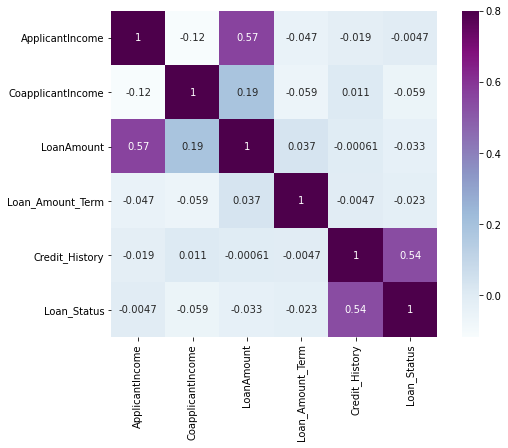

In [121]:
checkcorr = train.drop('LoanAmount_log',1)
matrix = checkcorr.corr()
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix,vmax=.8,square=True,cmap="BuPu", annot = True)

In [122]:
np.corrcoef(train['LoanAmount'], train['ApplicantIncome'])

array([[1.        , 0.56518052],
       [0.56518052, 1.        ]])

Correlation between loan amount and applicant income is 56%

In [123]:
np.corrcoef(train['LoanAmount'], train['CoapplicantIncome'])

array([[1.        , 0.18921778],
       [0.18921778, 1.        ]])

Correlation between loan amount and coapplicant income is 18%

In [124]:
np.corrcoef(train['Loan_Status'], train['Credit_History'])

array([[1.        , 0.54055607],
       [0.54055607, 1.        ]])

Correlation between Loan Status and Credit History is 54%

## Create Cleansed csv for backup

In [125]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1,4.852030
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,4.852030
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,4.189655
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4.787492
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,4.948760


In [126]:
test.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,LoanAmount_log
0,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,4.700480
1,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,4.836282
2,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,5.337538
3,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,1.0,Urban,4.605170
4,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,4.356709


In [127]:
#train.to_csv('Cleansed_train.csv', index=False)

In [128]:
#test.to_csv('Cleansed_test.csv', index=False)

## Check Point 1

We will use a new set of data frame for our modelling

In [129]:
train_model = pd.read_csv("https://github.com/DSstore/Loan/raw/main/Cleansed_train.csv")
test_model = pd.read_csv("https://github.com/DSstore/Loan/raw/main/Cleansed_test.csv")
train_model.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1,4.852030
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,4.852030
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,4.189655
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4.787492
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,4.948760


In [131]:
train_model.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
LoanAmount_log       0
dtype: int64

Based on the domain knowledge, we can come up with new feature that might affect target variable.
Total Income - After what we seen from bivariate analysis, we will combine the Applicant Income and Co-applicant Income to form total income
Equated Monthly Installment(EMI) - It is the monthly amount to be paid by applicant to repay loan. We can calculate the EMI by taking the ratio of loan amount with respect to loan amount term.
Balance Income - This is the income left after EMI has been paid. The idea creating this variable is that if this value is high, the chances are high that a person will repay the loan hence increasing the chances of loan approval.
1.If total income is high, the chances of loan approval is high.
2.If EMI is high, the chances of loan approval is low
3.If the balance income is high, the chances of loan approval is high

## Total Income

In [132]:
train_model['Total_Income'] = train_model['ApplicantIncome']+train_model['CoapplicantIncome']
test_model['Total_Income'] = test_model['ApplicantIncome']+test_model['CoapplicantIncome']
train_model

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log,Total_Income
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1,4.852030,5849.0
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,4.852030,6091.0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,4.189655,3000.0
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4.787492,4941.0
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,4.948760,6000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,1,4.262680,2900.0
610,Male,Yes,3,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,1,3.688879,4106.0
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,1,5.533389,8312.0
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,1,5.231109,7583.0


<AxesSubplot:xlabel='Total_Income', ylabel='Density'>

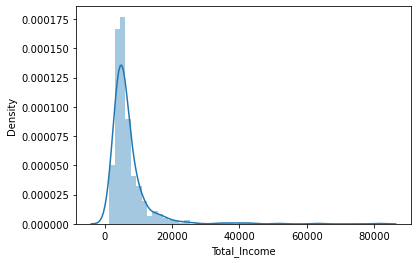

In [133]:
sns.distplot(train_model['Total_Income'])

As we can see, it is right skewed.

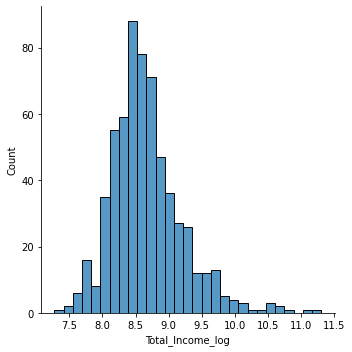

In [134]:
train_model['Total_Income_log'] = np.log(train_model['Total_Income'])
test_model['Total_Income_log'] = np.log(train_model['Total_Income'])
sns.displot(train_model['Total_Income_log'])

Now the distribution looks closer to normal and the effect of extreme values has been significantly subsided.

## Equated Monthly Installment (EMI)

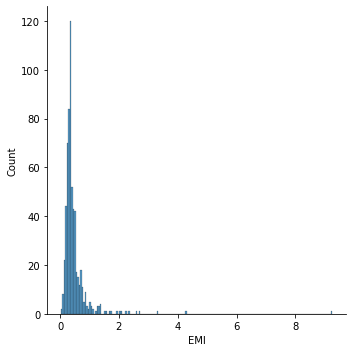

In [135]:
train_model['EMI']=train_model['LoanAmount']/train_model['Loan_Amount_Term']
test_model['EMI']=test_model['LoanAmount']/test_model['Loan_Amount_Term']
sns.displot(train_model['EMI'])

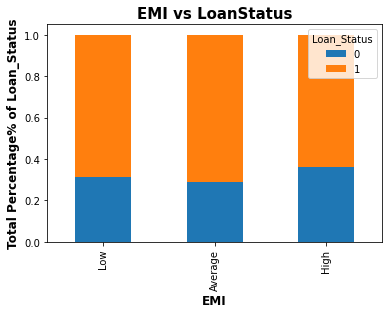

In [136]:
train_model['EMI_test']=train_model['EMI']*1000
bins=[0,300,500,9250]
group=['Low','Average','High']
train_model['EMI_bin']=pd.cut(train_model['EMI_test'],bins,labels=group)
EMI_bin=pd.crosstab(train_model['EMI_bin'],train_model['Loan_Status'])
EMI_bin.div(EMI_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.title('EMI vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('Total Percentage% of Loan_Status', fontweight='bold', size=12)
plt.xlabel('EMI', fontweight='bold', size=12)
plt.show()

## Balanced Income

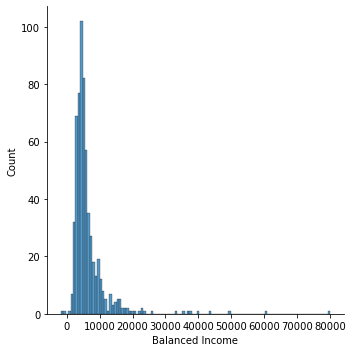

In [137]:
train_model['Balanced Income'] = train_model['Total_Income']-(train_model['EMI']*1000)
test_model['Balanced Income'] = test_model['Total_Income']-(test_model['EMI']*1000)
sns.displot(train_model['Balanced Income'])

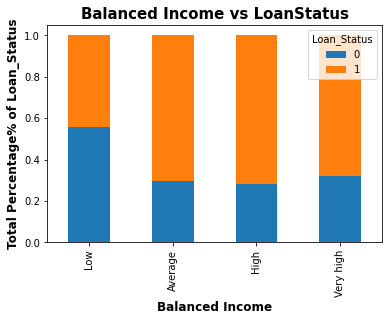

In [138]:
bins=[-2000,2500,5000,7000,80000]
group=['Low','Average','High','Very high']
train_model['Balanced_bin']=pd.cut(train_model['Balanced Income'],bins,labels=group)
Balanced_bin=pd.crosstab(train_model['Balanced_bin'],train_model['Loan_Status'])
Balanced_bin.div(Balanced_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.title('Balanced Income vs LoanStatus', fontweight='bold', size=15)
plt.ylabel('Total Percentage% of Loan_Status', fontweight='bold', size=12)
plt.xlabel('Balanced Income', fontweight='bold', size=12)
plt.show()

In [139]:
train_model

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log,Total_Income,Total_Income_log,EMI,EMI_test,EMI_bin,Balanced Income,Balanced_bin
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1,4.852030,5849.0,8.674026,0.355556,355.555556,Average,5493.444444,High
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,4.852030,6091.0,8.714568,0.355556,355.555556,Average,5735.444444,High
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,4.189655,3000.0,8.006368,0.183333,183.333333,Low,2816.666667,Average
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4.787492,4941.0,8.505323,0.333333,333.333333,Average,4607.666667,Average
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,4.948760,6000.0,8.699515,0.391667,391.666667,Average,5608.333333,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,1,4.262680,2900.0,7.972466,0.197222,197.222222,Low,2702.777778,Average
610,Male,Yes,3,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,1,3.688879,4106.0,8.320205,0.222222,222.222222,Low,3883.777778,Average
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,1,5.533389,8312.0,9.025456,0.702778,702.777778,High,7609.222222,Very high
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,1,5.231109,7583.0,8.933664,0.519444,519.444444,High,7063.555556,Very high


In [140]:
train_model=train_model.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term','EMI_test','EMI_bin','Balanced_bin'], axis=1 )
test_model=test_model.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)
train_model.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,LoanAmount_log,Total_Income,Total_Income_log,EMI,Balanced Income
0,Male,No,0,Graduate,No,1.0,Urban,1,4.852030,5849.0,8.674026,0.355556,5493.444444
1,Male,Yes,1,Graduate,No,1.0,Rural,0,4.852030,6091.0,8.714568,0.355556,5735.444444
2,Male,Yes,0,Graduate,Yes,1.0,Urban,1,4.189655,3000.0,8.006368,0.183333,2816.666667
3,Male,Yes,0,Not Graduate,No,1.0,Urban,1,4.787492,4941.0,8.505323,0.333333,4607.666667
4,Male,No,0,Graduate,No,1.0,Urban,1,4.948760,6000.0,8.699515,0.391667,5608.333333


In [141]:
#train_model.to_csv('feature_engineering_train.csv', index=False)
#test_model.to_csv('feature_engineering_test.csv', index=False)

## CheckPoint 2

## Dummy Variables for categorical variables

In [142]:
train_model = pd.read_csv("https://github.com/DSstore/Loan/raw/main/feature_engineering_train.csv")
test_model = pd.read_csv("https://github.com/DSstore/Loan/raw/main/feature_engineering_test.csv")
train_model

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,LoanAmount_log,Total_Income,Total_Income_log,EMI,Balanced Income
0,Male,No,0,Graduate,No,1.0,Urban,1,4.852030,5849.0,8.674026,0.355556,5493.444444
1,Male,Yes,1,Graduate,No,1.0,Rural,0,4.852030,6091.0,8.714568,0.355556,5735.444444
2,Male,Yes,0,Graduate,Yes,1.0,Urban,1,4.189655,3000.0,8.006368,0.183333,2816.666667
3,Male,Yes,0,Not Graduate,No,1.0,Urban,1,4.787492,4941.0,8.505323,0.333333,4607.666667
4,Male,No,0,Graduate,No,1.0,Urban,1,4.948760,6000.0,8.699515,0.391667,5608.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,1.0,Rural,1,4.262680,2900.0,7.972466,0.197222,2702.777778
610,Male,Yes,3,Graduate,No,1.0,Rural,1,3.688879,4106.0,8.320205,0.222222,3883.777778
611,Male,Yes,1,Graduate,No,1.0,Urban,1,5.533389,8312.0,9.025456,0.702778,7609.222222
612,Male,Yes,2,Graduate,No,1.0,Urban,1,5.231109,7583.0,8.933664,0.519444,7063.555556


In [143]:
X = train_model.drop('Loan_Status',1)
y = train_model.Loan_Status
X

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,LoanAmount_log,Total_Income,Total_Income_log,EMI,Balanced Income
0,Male,No,0,Graduate,No,1.0,Urban,4.852030,5849.0,8.674026,0.355556,5493.444444
1,Male,Yes,1,Graduate,No,1.0,Rural,4.852030,6091.0,8.714568,0.355556,5735.444444
2,Male,Yes,0,Graduate,Yes,1.0,Urban,4.189655,3000.0,8.006368,0.183333,2816.666667
3,Male,Yes,0,Not Graduate,No,1.0,Urban,4.787492,4941.0,8.505323,0.333333,4607.666667
4,Male,No,0,Graduate,No,1.0,Urban,4.948760,6000.0,8.699515,0.391667,5608.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,1.0,Rural,4.262680,2900.0,7.972466,0.197222,2702.777778
610,Male,Yes,3,Graduate,No,1.0,Rural,3.688879,4106.0,8.320205,0.222222,3883.777778
611,Male,Yes,1,Graduate,No,1.0,Urban,5.533389,8312.0,9.025456,0.702778,7609.222222
612,Male,Yes,2,Graduate,No,1.0,Urban,5.231109,7583.0,8.933664,0.519444,7063.555556


The dummy variable turns categorical variables into a series of 0 and 1, which makes them a lot easier to quantify and compare.
Let us understand what is the dummies process
1. Consider the 'Gender' variable. It has 2 classes, Male and Female.
2. Logistic Regression only takes numerical values as input
3. Once we apply the dummies process into this variable, it will convert the 'Gender' variable in two variables. 'Gender_Female' & 'Gender_Male'
4. Gender_Male will have a value of 1 if the gender is a male, value of 0 if the gender is female
5. Gender_Female on the other hand, will have a value of 1 if the gender is female, and value of 1 if the gender is male

In [144]:
X = pd.get_dummies(X)
train_model=pd.get_dummies(train_model)
test_model=pd.get_dummies(test_model)

In [145]:
X.head(5)

,Dependents,Credit_History,LoanAmount_log,Total_Income,Total_Income_log,EMI,Balanced Income,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,1.0,4.852030,5849.0,8.674026,0.355556,5493.444444,0,1,1,0,1,0,1,0,0,0,1
1,1,1.0,4.852030,6091.0,8.714568,0.355556,5735.444444,0,1,0,1,1,0,1,0,1,0,0
2,0,1.0,4.189655,3000.0,8.006368,0.183333,2816.666667,0,1,0,1,1,0,0,1,0,0,1
3,0,1.0,4.787492,4941.0,8.505323,0.333333,4607.666667,0,1,0,1,0,1,1,0,0,0,1
4,0,1.0,4.948760,6000.0,8.699515,0.391667,5608.333333,0,1,1,0,1,0,1,0,0,0,1


In [146]:
y

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

In [147]:
test_model

,Dependents,Credit_History,LoanAmount_log,Total_Income,Total_Income_log,EMI,Balanced Income,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,1.0,4.700480,5720,8.674026,0.305556,5414.444444,0,1,0,1,1,0,1,0,0,0,1
1,1,1.0,4.836282,4576,8.714568,0.350000,4226.000000,0,1,0,1,1,0,1,0,0,0,1
2,2,1.0,5.337538,6800,8.006368,0.577778,6222.222222,0,1,0,1,1,0,1,0,0,0,1
3,2,1.0,4.605170,4886,8.505323,0.277778,4608.222222,0,1,0,1,1,0,1,0,0,0,1
4,0,1.0,4.356709,3276,8.699515,0.216667,3059.333333,0,1,1,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,3,1.0,4.727388,5786,8.865453,0.313889,5472.111111,0,1,0,1,0,1,0,1,0,0,1
363,0,1.0,4.744932,4867,8.707152,0.319444,4547.555556,0,1,0,1,1,0,1,0,0,0,1
364,0,1.0,4.836282,5243,8.827908,0.350000,4893.000000,0,1,1,0,1,0,1,0,0,1,0
365,0,1.0,5.062595,7393,8.734882,0.438889,6954.111111,0,1,0,1,1,0,1,0,1,0,0


Let us make our first model that predict the target variable. We start off with Logistic Regression which is used for predicting binary outcome
1. Logistic Regression is a classification algorithm that is used to predict a binary outcome (1/0, Yes/No, True,False).
2. Logistic regression is an estimation of Logit Function. A logit function is simply a log of  odds in favor of the event
3. The function will create a S-shaped Curve with probability estimate shown in the image below

## Splitting of Train Data Set

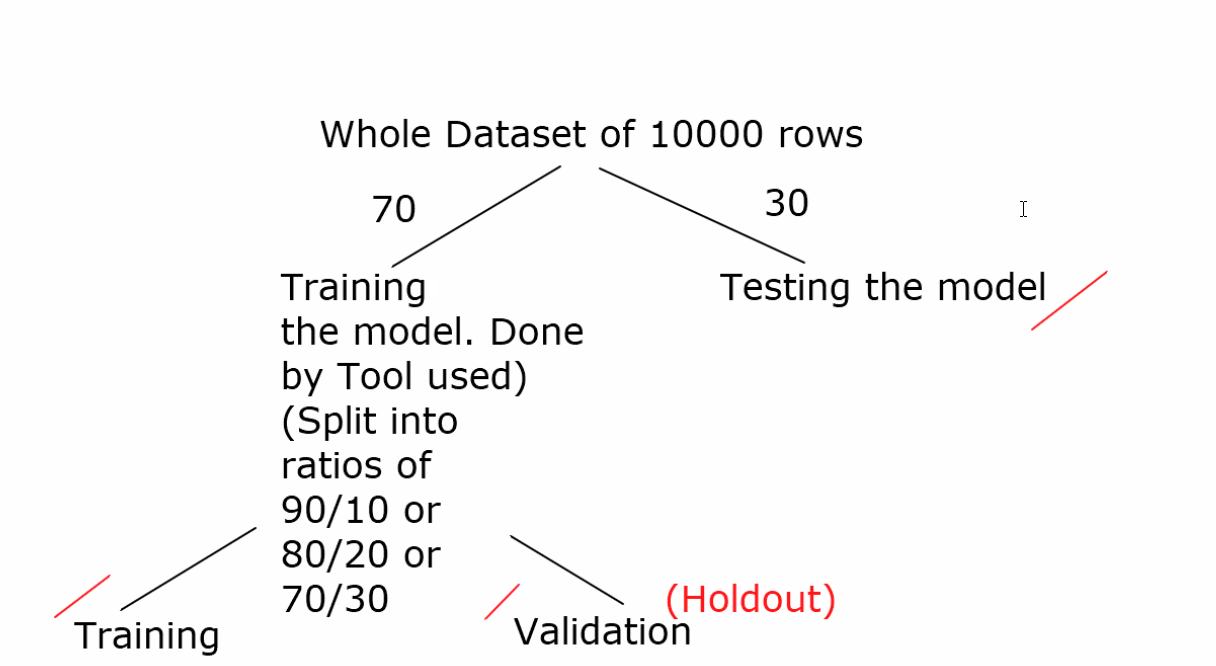

In [148]:
Image("https://raw.githubusercontent.com/DSstore/Loan/main/image/Splittingupdata.png")

Now we divide our train dataset into 2 parts: Train and Validation
We can train the model on the Train part and using that to make predictions for the Validation part
This way, we can validate our predictions as we have the true predictions for the validation part (Which we do not have for the test dataset)

We will use train_test_split function from sklearn to divide our train dataset

In [149]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.7, test_size=0.3, random_state=50)

In [150]:
x_train

,Dependents,Credit_History,LoanAmount_log,Total_Income,Total_Income_log,EMI,Balanced Income,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
25,0,1.0,5.252273,9560.0,9.165343,0.530556,9029.444444,0,1,0,1,1,0,0,1,0,1,0
263,0,1.0,4.787492,7200.0,8.881836,0.333333,6866.666667,1,0,1,0,1,0,1,0,1,0,0
562,0,1.0,5.351858,7977.0,8.984318,0.586111,7390.888889,0,1,0,1,1,0,1,0,1,0,0
588,0,1.0,4.543295,4750.0,8.465900,0.261111,4488.888889,0,1,1,0,1,0,1,0,0,1,0
120,0,1.0,5.192957,8334.0,9.028099,0.500000,7834.000000,0,1,0,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0,1.0,5.147494,6274.0,8.744169,0.477778,5796.222222,0,1,0,1,1,0,1,0,0,0,1
132,0,1.0,4.248495,2718.0,7.907652,0.194444,2523.555556,0,1,1,0,1,0,1,0,0,1,0
289,0,1.0,5.231109,9508.0,9.159889,0.519444,8988.555556,0,1,1,0,1,0,1,0,1,0,0
109,3,1.0,4.543295,2825.0,7.946264,0.195833,2629.166667,0,1,0,1,0,1,1,0,0,1,0


In [151]:
y_train

25     1
263    1
562    1
588    1
120    1
      ..
70     1
132    1
289    1
109    1
480    1
Name: Loan_Status, Length: 429, dtype: int64

In [152]:
x_test

,Dependents,Credit_History,LoanAmount_log,Total_Income,Total_Income_log,EMI,Balanced Income,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
18,0,1.0,4.890349,4887.0,8.494334,0.369444,4517.555556,0,1,0,1,0,1,1,0,1,0,0
175,0,1.0,4.753590,5461.0,8.605387,0.322222,5138.777778,0,1,0,1,1,0,1,0,1,0,0
287,0,1.0,4.787492,5704.0,8.648923,0.333333,5370.666667,0,1,0,1,1,0,1,0,1,0,0
409,3,0.0,5.886104,81000.0,11.302204,1.000000,80000.000000,0,1,0,1,1,0,1,0,1,0,0
302,0,1.0,4.882802,5000.0,8.517193,0.366667,4633.333333,1,0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,2,0.0,4.663439,2726.0,7.910591,0.294444,2431.555556,0,1,0,1,1,0,0,1,0,1,0
94,0,1.0,3.218876,3620.0,8.194229,0.208333,3411.666667,0,1,1,0,0,1,1,0,0,1,0
177,3,0.0,6.204558,16816.0,9.730086,1.375000,15441.000000,0,1,0,1,1,0,1,0,0,1,0
586,0,1.0,4.644391,3819.0,8.247744,0.288889,3530.111111,0,1,0,1,1,0,1,0,0,0,1


In [153]:
y_test

18     0
175    1
287    1
409    0
302    1
      ..
589    0
94     1
177    0
586    1
455    1
Name: Loan_Status, Length: 185, dtype: int64

Now the dataset has been divided into training and validation part.
Now let us import the LogisticRegression and accuracy_score from sklearn and fit the logistic regression model

## Implement basic models

We define a loss function that is able to calculate the precision score, recall score and accuracy score of a ML model

In [154]:
def loss(y_true, y_pred):
    pre= precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    print('Accuracy:',acc)
    print("Precision:",pre)
    print('Recall:',rec)

In [155]:
#Confusion Matrix Function

def plot_confusion_matrix(cm, classes=None, title='Confusion Matrix'):
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu",xticklabels=classes, yticklabels=classes, vmin=0, vmax=1, annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0, vmax=1)
    plt.title(title)
    plt.ylabel('True Lable')
    plt.xlabel('Predicted Label')

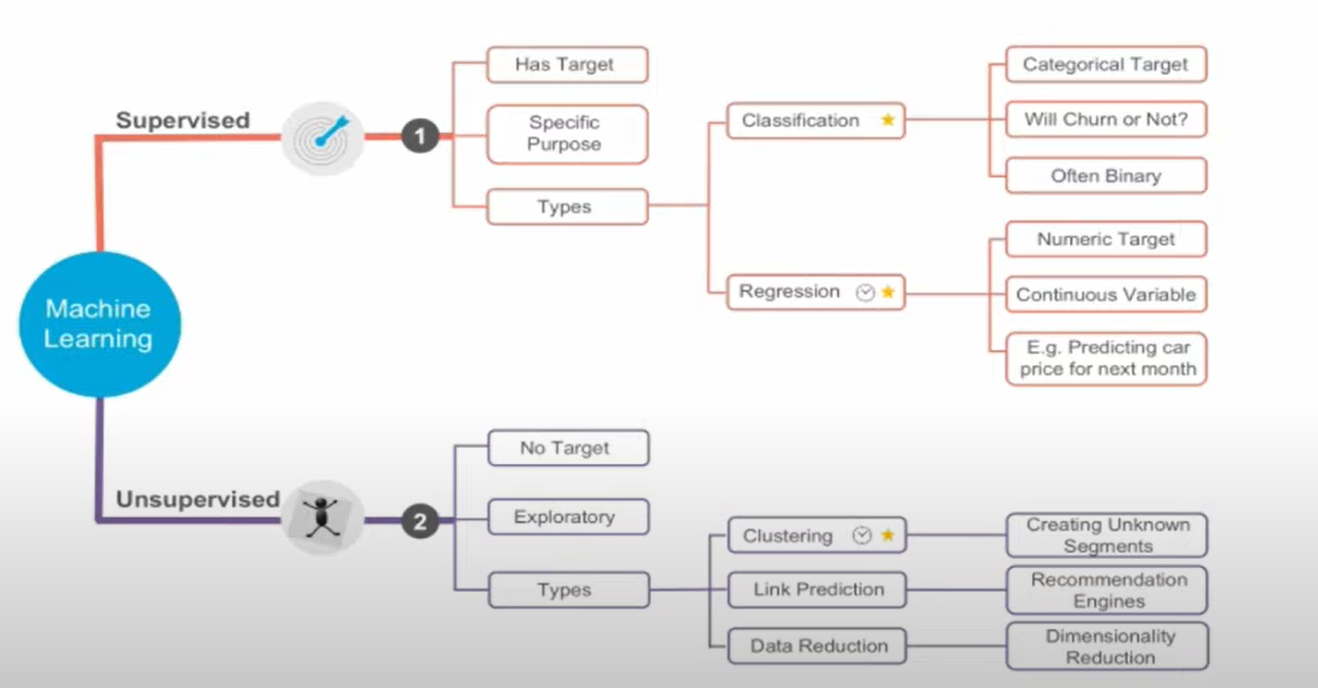

In [156]:
Image("https://raw.githubusercontent.com/DSstore/Loan/main/image/ChoosingModel.png")

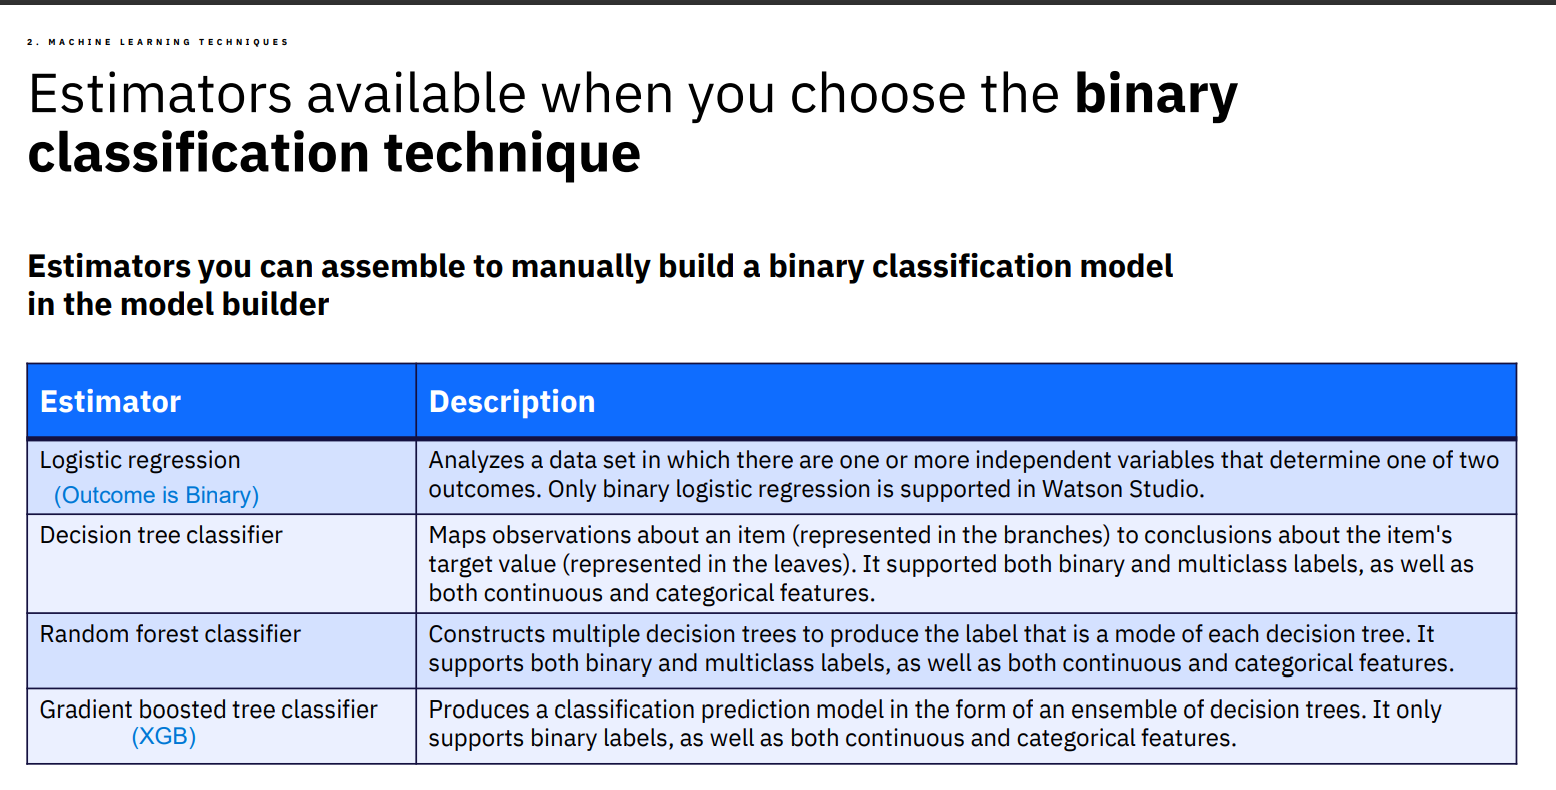

In [157]:
Image("https://raw.githubusercontent.com/DSstore/Loan/main/image/binaryclassification.png")

## Logistic Regression

Let us make our first model that predict the target variable. We start off with Logistic Regression which is used for predicting binary outcome
1.Logistic Regression is a classification algorithm that is used to predict a binary outcome (1/0, Yes/No, True,False).
2.Logistic regression is an estimation of Logit Function(Sigmoid). A logit function is simply a log of odds in favor of the event
3.The function will create a S-shaped Curve with probability estimate shown in the image below

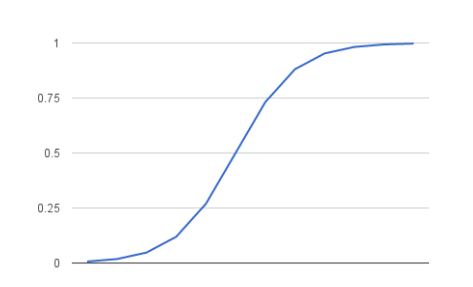

In [158]:
Image("https://raw.githubusercontent.com/DSstore/Loan/main/image/LogisticRegression.png")

Restrictions when implementing Logistic Regression
1.It can only be applied to large datasets
2.The dependent variable has to be binary in binary logistic equation
3.The factor level 1 of the dependent variable should represent the desired outcome
4.Non-meaningful variables may cause errors. Only include the variables that are necessary and may show a correlation
5.The independent variable should be absolutely independent of each other
6.The independent variables are linearly related to the log odds

In [159]:
model = LogisticRegression()
model.fit(x_train, y_train)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                   penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)
pred_y = model.predict(x_train)
pred_proba = model.predict_proba(x_train)

In [160]:
#Accuracy on Train
print("The Train Accuracy is: ", model.score(x_train,y_train))
#Accuracy on Test
print("The Test Accuracy is: ", model.score(x_test,y_test))
#Classification Report
print(classification_report(y_train,pred_y))
#Confusion Matrix
cm = confusion_matrix(y_train,pred_y)
cm

The Train Accuracy is:  0.8135198135198135
The Test Accuracy is:  0.772972972972973
              precision    recall  f1-score   support

           0       0.84      0.48      0.61       130
           1       0.81      0.96      0.88       299

    accuracy                           0.81       429
   macro avg       0.82      0.72      0.74       429
weighted avg       0.82      0.81      0.80       429



array([[ 62,  68],
       [ 12, 287]], dtype=int64)

So our predictions are roughly 80% accurate such that we have identified 80% of the loan status correctly.


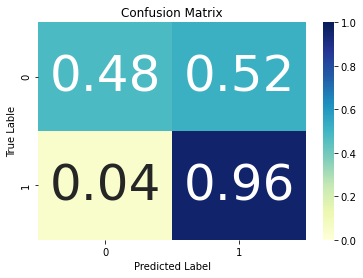

In [161]:
cm_norm = cm/cm.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm, classes=model.classes_,title='Confusion Matrix')

## Stratified k-folds cross-validation on Logistic Regression


1 of kfold 5 
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        38
           1       0.82      1.00      0.90        85

    accuracy                           0.85       123
   macro avg       0.91      0.75      0.78       123
weighted avg       0.87      0.85      0.83       123

The current confusion matrix is
 [[19 19]
 [ 0 85]]


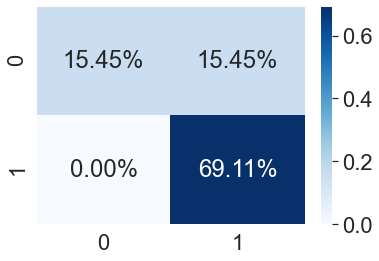


2 of kfold 5 
              precision    recall  f1-score   support

           0       0.94      0.42      0.58        38
           1       0.79      0.99      0.88        85

    accuracy                           0.81       123
   macro avg       0.87      0.70      0.73       123
weighted avg       0.84      0.81      0.79       123

The current confusion matrix is
 [[16 22]
 [ 1 84]]


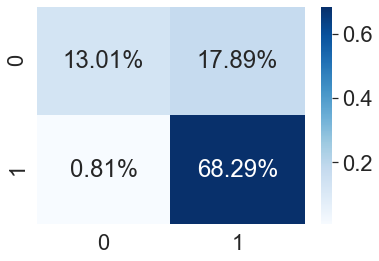


3 of kfold 5 
              precision    recall  f1-score   support

           0       0.83      0.38      0.53        39
           1       0.77      0.96      0.86        84

    accuracy                           0.78       123
   macro avg       0.80      0.67      0.69       123
weighted avg       0.79      0.78      0.75       123

The current confusion matrix is
 [[15 24]
 [ 3 81]]


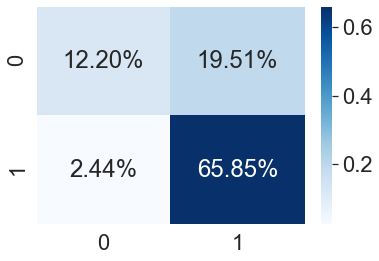


4 of kfold 5 
              precision    recall  f1-score   support

           0       0.93      0.36      0.52        39
           1       0.77      0.99      0.86        84

    accuracy                           0.79       123
   macro avg       0.85      0.67      0.69       123
weighted avg       0.82      0.79      0.75       123

The current confusion matrix is
 [[14 25]
 [ 1 83]]


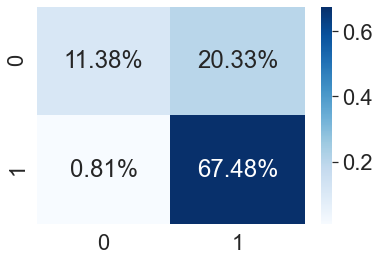


5 of kfold 5 
              precision    recall  f1-score   support

           0       0.90      0.47      0.62        38
           1       0.80      0.98      0.88        84

    accuracy                           0.82       122
   macro avg       0.85      0.72      0.75       122
weighted avg       0.83      0.82      0.80       122

The current confusion matrix is
 [[18 20]
 [ 2 82]]


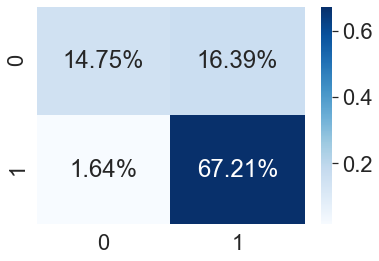


Mean Validation Accuracy 0.8094628815140611
Mean Validation Precision 0.7907258362141825
Mean Validation Recall 0.9833613445378152

Mean Validation CM


<AxesSubplot:>

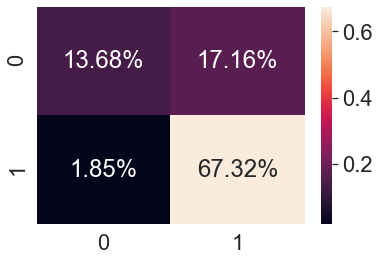

In [163]:
i=1
mean = 0
mean2 = 0
mean3 = 0
cmtotal = 0
meandf = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall'])
kf = StratifiedKFold(n_splits=5, random_state=50, shuffle=True)
for train_index,test_index in kf.split(X,y):
    print ('\n{} of kfold {} '.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                               intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                               penalty='l2', random_state=20, solver='liblinear', tol=0.0001,
                               verbose=0, warm_start=False)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    prec=precision_score(yvl, pred_test)
    rec=recall_score(yvl, pred_test)
    mean += score
    mean2 += prec
    mean3 += rec
    cmtotal += cm
    print(classification_report(yvl,pred_test))
    cm = confusion_matrix(yvl,pred_test)
    print('The current confusion matrix is\n',cm)
    sns.set(font_scale=2)
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    i+=1
    pred_test = model.predict(test_model)
    pred_proba_LogR = model.predict_proba(xvl)[:,1]
meanacc = mean/(i-1)
meanpre = mean2/(i-1)
meanrec = mean3/(i-1)
LogR_y = yvl
print ('\nMean Validation Accuracy',meanacc)
print('Mean Validation Precision', meanpre)
print('Mean Validation Recall', meanrec)
meandf.loc['LogisticR'] = [meanacc,meanpre,meanrec]
print('\nMean Validation CM')
sns.heatmap((cmtotal/np.sum(cmtotal)), annot=True, fmt='.2%')

In [164]:
meandf

,Accuracy,Precision,Recall
LogisticR,0.809463,0.790726,0.983361


## Receiver Operating Characteristic

The ROC curve summarizes the prediction performance of a classification model at all classification thresholds. Particularly, the ROC curve plots the False Positive Rate (FPR) on the X-axis and the True Positive Rate (TPR) on the Y-axis.

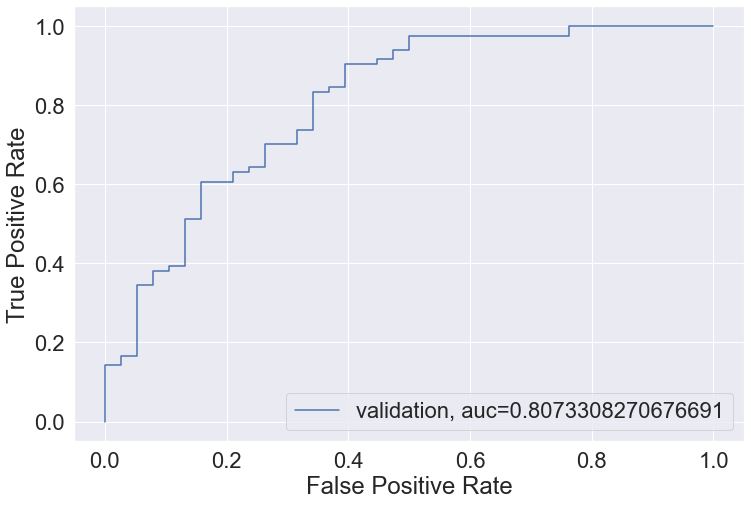

In [165]:
fpr, tpr, _ = metrics.roc_curve(LogR_y, pred_proba_LogR)
auc = metrics.roc_auc_score(LogR_y, pred_proba_LogR)
plt.figure(figsize=(12,8))
meandf['Roc_Auc'] = auc
plt.plot(fpr, tpr, label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [166]:
meandf

,Accuracy,Precision,Recall,Roc_Auc
LogisticR,0.809463,0.790726,0.983361,0.807331


Create result from with submission as sample , to compare the results with AutoGluon

In [172]:
test = pd.read_csv("https://github.com/DSstore/Loan/raw/main/test.csv")
submission = pd.read_csv("https://github.com/DSstore/Loan/raw/main/sample_submission.csv")
submission['Loan_Status']=pred_test
submission['Loan_ID']=test['Loan_ID']
submission['Loan_Status'].replace(0,'N', inplace=True)
submission['Loan_Status'].replace(1, 'Y', inplace=True)
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('logisticregression.csv')
submission

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
...,...,...
362,LP002971,Y
363,LP002975,Y
364,LP002980,Y
365,LP002986,Y


## Decision Tree (Stratified k-folds cross-validation)


1 of kfold 5 
              precision    recall  f1-score   support

           0       0.86      0.47      0.61        38
           1       0.80      0.96      0.88        85

    accuracy                           0.81       123
   macro avg       0.83      0.72      0.74       123
weighted avg       0.82      0.81      0.79       123

The current confusion matrix is
 [[18 20]
 [ 3 82]]


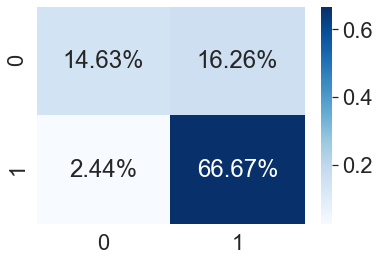


2 of kfold 5 
              precision    recall  f1-score   support

           0       1.00      0.47      0.64        38
           1       0.81      1.00      0.89        85

    accuracy                           0.84       123
   macro avg       0.90      0.74      0.77       123
weighted avg       0.87      0.84      0.82       123

The current confusion matrix is
 [[18 20]
 [ 0 85]]


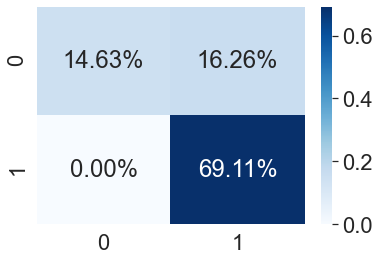


3 of kfold 5 
              precision    recall  f1-score   support

           0       0.94      0.38      0.55        39
           1       0.78      0.99      0.87        84

    accuracy                           0.80       123
   macro avg       0.86      0.69      0.71       123
weighted avg       0.83      0.80      0.77       123

The current confusion matrix is
 [[15 24]
 [ 1 83]]


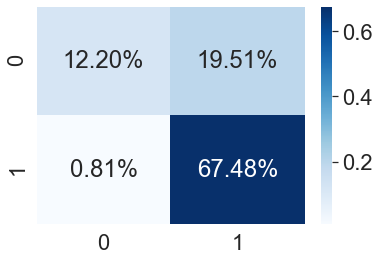


4 of kfold 5 
              precision    recall  f1-score   support

           0       0.89      0.44      0.59        39
           1       0.79      0.98      0.87        84

    accuracy                           0.80       123
   macro avg       0.84      0.71      0.73       123
weighted avg       0.82      0.80      0.78       123

The current confusion matrix is
 [[17 22]
 [ 2 82]]


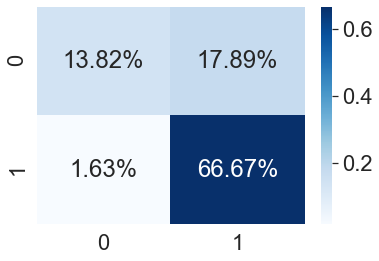


5 of kfold 5 
              precision    recall  f1-score   support

           0       0.93      0.37      0.53        38
           1       0.78      0.99      0.87        84

    accuracy                           0.80       122
   macro avg       0.85      0.68      0.70       122
weighted avg       0.82      0.80      0.76       122

The current confusion matrix is
 [[14 24]
 [ 1 83]]


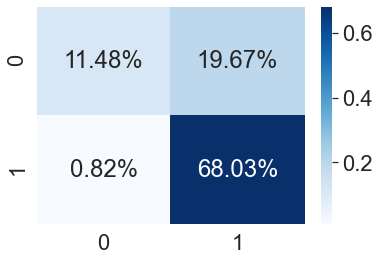


Mean Validation Accuracy 0.8094228975076636
Mean Validation Precision 0.7906617571543355
Mean Validation Recall 0.9834173669467787

Mean Validation CM


<AxesSubplot:>

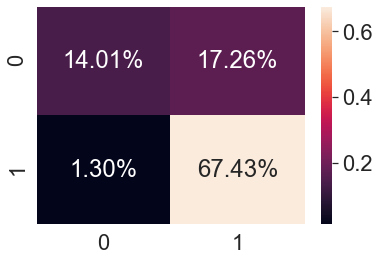

In [174]:
i=1
mean = 0
mean2 = 0
mean3 = 0
cmtotal = 0
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
for train_index,test_index in kf.split(X,y):
    print ('\n{} of kfold {} '.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    modeltree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=20, random_state=1)
    modeltree.fit(xtr,ytr)
    pred_tree_y=model.predict(xvl)
    score=accuracy_score(yvl,pred_tree_y)
    prec=precision_score(yvl, pred_tree_y)
    rec=recall_score(yvl, pred_tree_y)
    mean += score
    mean2 += prec
    mean3 += rec
    cmtotal += cm
    print(classification_report(yvl,pred_tree_y))
    cm = confusion_matrix(yvl,pred_tree_y)
    print('The current confusion matrix is\n',cm)
    sns.set(font_scale=2)
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    i+=1
    pred_test = modeltree.predict(test_model)
    pred_proba_tree = modeltree.predict_proba(xvl)[:,1]
meanacc = mean/(i-1)
meanpre = mean2/(i-1)
meanrec = mean3/(i-1)
DecT_y = yvl
print ('\nMean Validation Accuracy',meanacc)
print('Mean Validation Precision', meanpre)
print('Mean Validation Recall', meanrec)
print('\nMean Validation CM')
sns.heatmap((cmtotal/np.sum(cmtotal)), annot=True, fmt='.2%')

<AxesSubplot:title={'center':'Importance Score'}, xlabel='Importance', ylabel='Features'>

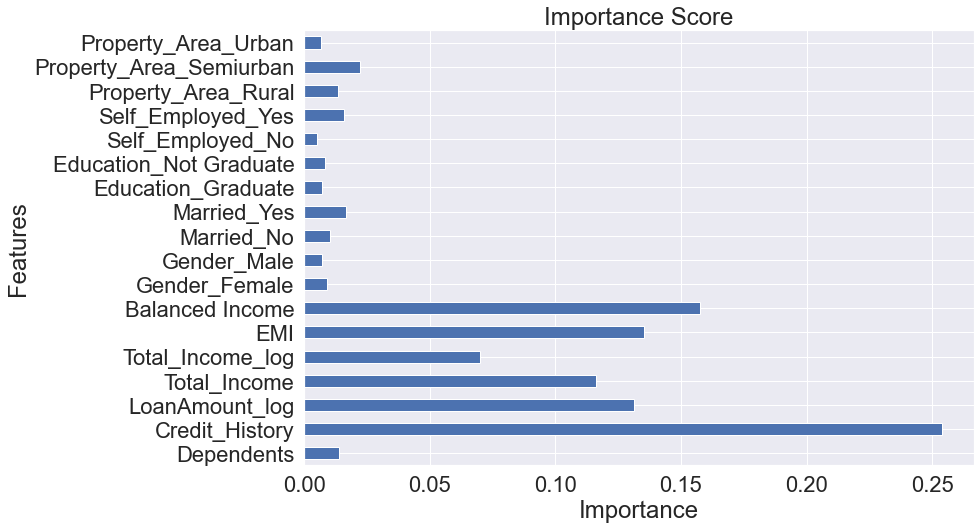

In [175]:
importances=pd.Series(modeltree.feature_importances_, index=X.columns)
plt.ylabel("Features")
plt.xlabel("Importance")
plt.title("Importance Score")
importances.plot(kind='barh', figsize=(12,8))

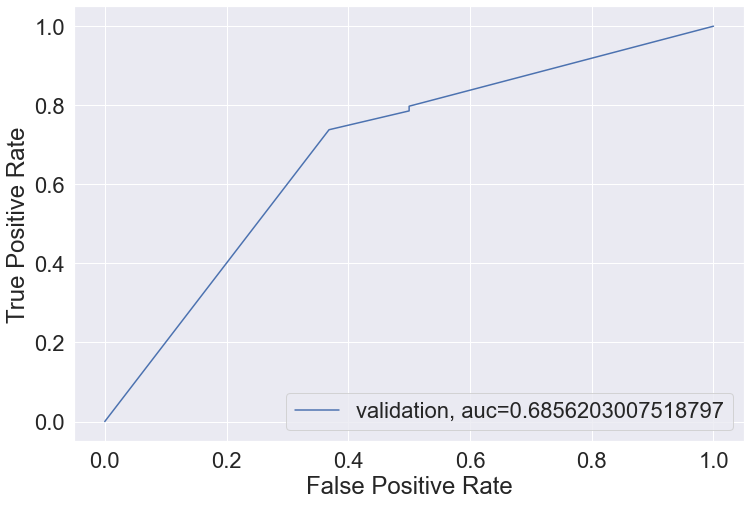

In [176]:
fpr, tpr, _ = metrics.roc_curve(DecT_y, pred_proba_tree)
auc = metrics.roc_auc_score(DecT_y, pred_proba_tree)
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [177]:
meandf.loc['DecisionTree'] = [meanacc,meanpre,meanrec,auc]
meandf

,Accuracy,Precision,Recall,Roc_Auc
LogisticR,0.809463,0.790726,0.983361,0.807331
DecisionTree,0.809423,0.790662,0.983417,0.685620


## Random Forest (Stratified k-folds cross-validation)


1 of kfold 5 
              precision    recall  f1-score   support

           0       0.75      0.47      0.58        38
           1       0.80      0.93      0.86        85

    accuracy                           0.79       123
   macro avg       0.77      0.70      0.72       123
weighted avg       0.78      0.79      0.77       123

The current confusion matrix is
 [[18 20]
 [ 6 79]]


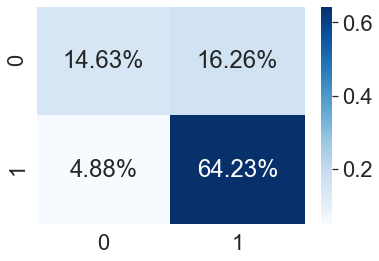


2 of kfold 5 
              precision    recall  f1-score   support

           0       0.72      0.47      0.57        38
           1       0.80      0.92      0.85        85

    accuracy                           0.78       123
   macro avg       0.76      0.70      0.71       123
weighted avg       0.77      0.78      0.77       123

The current confusion matrix is
 [[18 20]
 [ 7 78]]


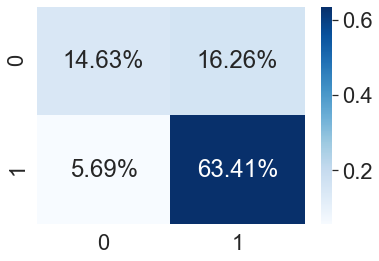


3 of kfold 5 
              precision    recall  f1-score   support

           0       0.67      0.46      0.55        39
           1       0.78      0.89      0.83        84

    accuracy                           0.76       123
   macro avg       0.72      0.68      0.69       123
weighted avg       0.74      0.76      0.74       123

The current confusion matrix is
 [[18 21]
 [ 9 75]]


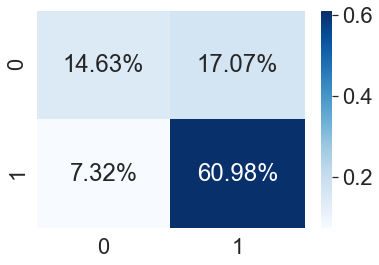


4 of kfold 5 
              precision    recall  f1-score   support

           0       0.92      0.56      0.70        39
           1       0.83      0.98      0.90        84

    accuracy                           0.85       123
   macro avg       0.87      0.77      0.80       123
weighted avg       0.86      0.85      0.83       123

The current confusion matrix is
 [[22 17]
 [ 2 82]]


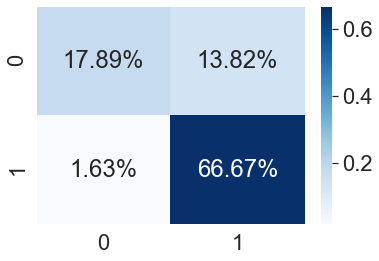


5 of kfold 5 
              precision    recall  f1-score   support

           0       0.71      0.45      0.55        38
           1       0.79      0.92      0.85        84

    accuracy                           0.77       122
   macro avg       0.75      0.68      0.70       122
weighted avg       0.76      0.77      0.75       122

The current confusion matrix is
 [[17 21]
 [ 7 77]]


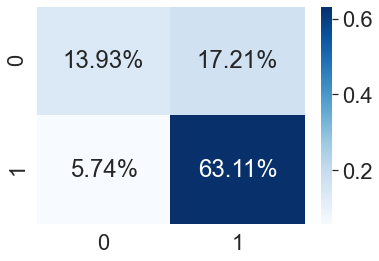


Mean Validation Accuracy 0.7882447021191524
Mean Validation Precision 0.79782905586477
Mean Validation Recall 0.9265546218487396

Mean Validation CM


<AxesSubplot:>

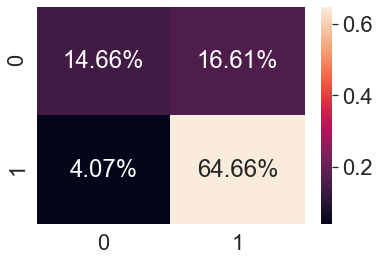

In [179]:
i=1
mean = 0
mean2 = 0
mean3 = 0
cmtotal = 0
kf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
for train_index,test_index in kf.split(X,y):
    print ('\n{} of kfold {} '.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    modelrandom = RandomForestClassifier(random_state=15, max_depth=25)
    modelrandom.fit(xtr,ytr)
    pred_random_y=modelrandom.predict(xvl)
    score=accuracy_score(yvl,pred_random_y)
    prec=precision_score(yvl, pred_random_y)
    rec=recall_score(yvl, pred_random_y)
    mean += score
    mean2 += prec
    mean3 += rec
    cmtotal += cm
    print(classification_report(yvl,pred_random_y))
    cm = confusion_matrix(yvl,pred_random_y)
    print('The current confusion matrix is\n',cm)
    sns.set(font_scale=2)
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    i+=1
    pred_test = model.predict(test_model)
    pred_proba_random = model.predict_proba(xvl)[:,1]
meanacc = mean/(i-1)
meanpre = mean2/(i-1)
meanrec = mean3/(i-1)
RanT = yvl
print ('\nMean Validation Accuracy',meanacc)
print('Mean Validation Precision', meanpre)
print('Mean Validation Recall', meanrec)
print('\nMean Validation CM')
sns.heatmap((cmtotal/np.sum(cmtotal)), annot=True, fmt='.2%')

<AxesSubplot:title={'center':'Importance Score'}, xlabel='Importance', ylabel='Features'>

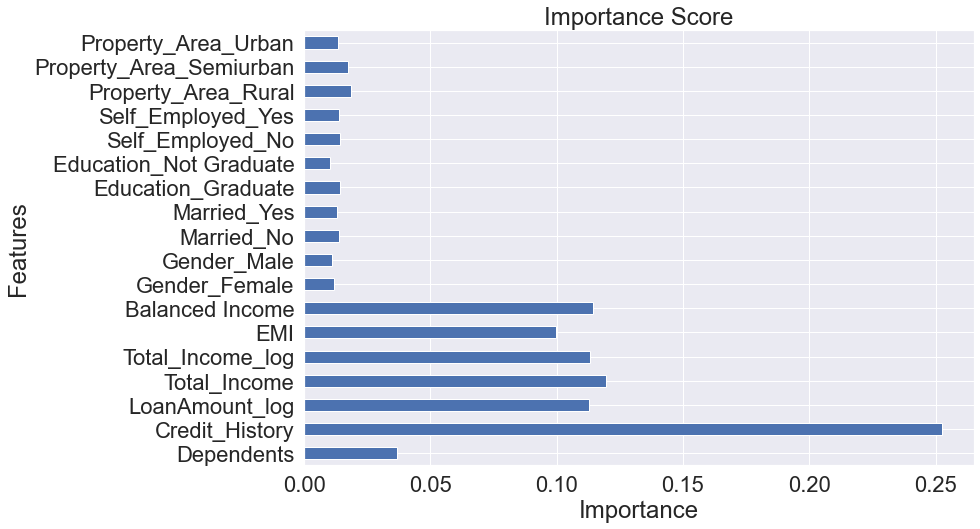

In [180]:
importances=pd.Series(modelrandom.feature_importances_, index=X.columns)
plt.ylabel("Features")
plt.xlabel("Importance")
plt.title("Importance Score")
importances.plot(kind='barh', figsize=(12,8))

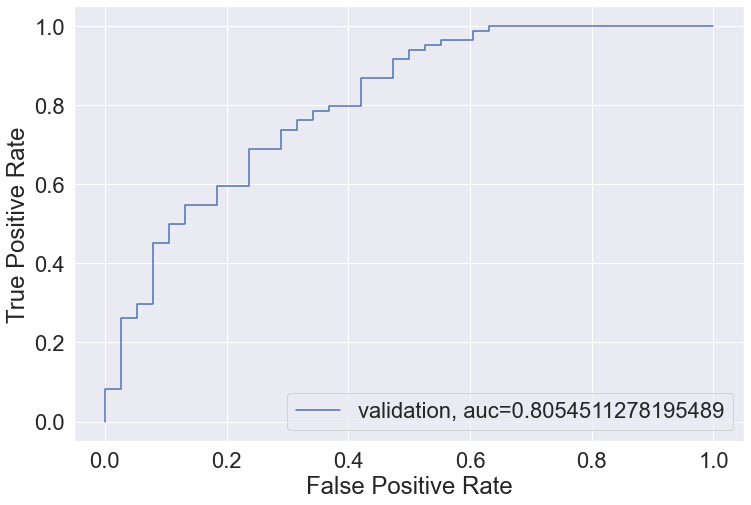

In [181]:
fpr, tpr, _ = metrics.roc_curve(RanT, pred_proba_random)
auc = metrics.roc_auc_score(RanT, pred_proba_random)
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [182]:
meandf.loc['RandomTree'] = [meanacc,meanpre,meanrec,auc]
meandf

,Accuracy,Precision,Recall,Roc_Auc
LogisticR,0.809463,0.790726,0.983361,0.807331
DecisionTree,0.809423,0.790662,0.983417,0.685620
RandomTree,0.788245,0.797829,0.926555,0.805451


## XGBClassifer ((Stratified k-folds cross-validation))


1 of kfold 5 
[22:56:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.52      0.45      0.48        38
           1       0.77      0.81      0.79        85

    accuracy                           0.70       123
   macro avg       0.64      0.63      0.63       123
weighted avg       0.69      0.70      0.69       123

The current confusion matrix is
 [[17 21]
 [16 69]]


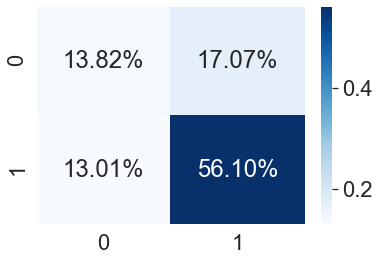


2 of kfold 5 
[22:56:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        38
           1       0.81      0.88      0.84        85

    accuracy                           0.77       123
   macro avg       0.74      0.70      0.72       123
weighted avg       0.76      0.77      0.76       123

The current confusion matrix is
 [[20 18]
 [10 75]]


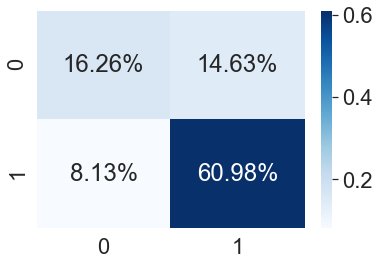


3 of kfold 5 
[22:56:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.65      0.51      0.57        39
           1       0.79      0.87      0.83        84

    accuracy                           0.76       123
   macro avg       0.72      0.69      0.70       123
weighted avg       0.75      0.76      0.75       123

The current confusion matrix is
 [[20 19]
 [11 73]]


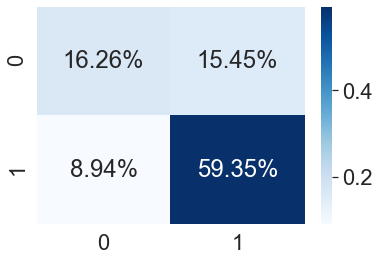


4 of kfold 5 
[22:56:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.81      0.56      0.67        39
           1       0.82      0.94      0.88        84

    accuracy                           0.82       123
   macro avg       0.82      0.75      0.77       123
weighted avg       0.82      0.82      0.81       123

The current confusion matrix is
 [[22 17]
 [ 5 79]]


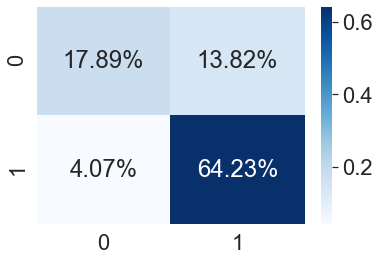


5 of kfold 5 
[22:56:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.67      0.47      0.55        38
           1       0.79      0.89      0.84        84

    accuracy                           0.76       122
   macro avg       0.73      0.68      0.70       122
weighted avg       0.75      0.76      0.75       122

The current confusion matrix is
 [[18 20]
 [ 9 75]]


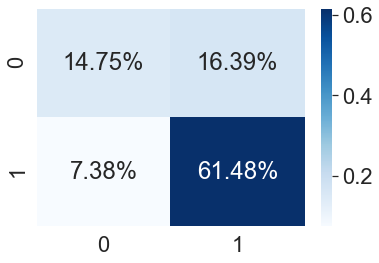


Mean Validation Accuracy 0.7622151139544182
Mean Validation Precision 0.7957973782633301
Mean Validation Recall 0.8792997198879553

Mean Validation CM


<AxesSubplot:>

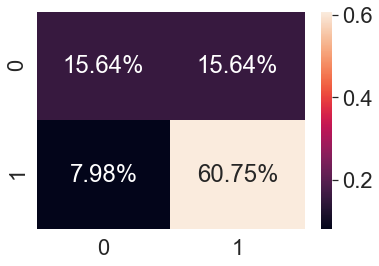

In [183]:
i=1
mean = 0
mean2 = 0
mean3 = 0
cmtotal = 0
kf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
for train_index,test_index in kf.split(X,y):
    print ('\n{} of kfold {} '.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    modelXGB = XGBClassifier(n_estimators=200, max_depth=4)
    modelXGB.fit(xtr,ytr)
    pred_XGB_y=modelXGB.predict(xvl)
    score=accuracy_score(yvl,pred_XGB_y)
    prec=precision_score(yvl, pred_XGB_y)
    rec=recall_score(yvl, pred_XGB_y)
    mean += score
    mean2 += prec
    mean3 += rec
    cmtotal += cm
    print(classification_report(yvl,pred_XGB_y))
    cm = confusion_matrix(yvl,pred_XGB_y)
    print('The current confusion matrix is\n',cm)
    sns.set(font_scale=2)
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    i+=1
    pred_test = modelXGB.predict(test_model)
    pred_XGB_proba = model.predict_proba(xvl)[:,1]
meanacc = mean/(i-1)
meanpre = mean2/(i-1)
meanrec = mean3/(i-1)
XBG_y = yvl
print ('\nMean Validation Accuracy',meanacc)
print('Mean Validation Precision', meanpre)
print('Mean Validation Recall', meanrec)
print('\nMean Validation CM')
sns.heatmap((cmtotal/np.sum(cmtotal)), annot=True, fmt='.2%')

<AxesSubplot:title={'center':'Importance Score'}, xlabel='Importance', ylabel='Features'>

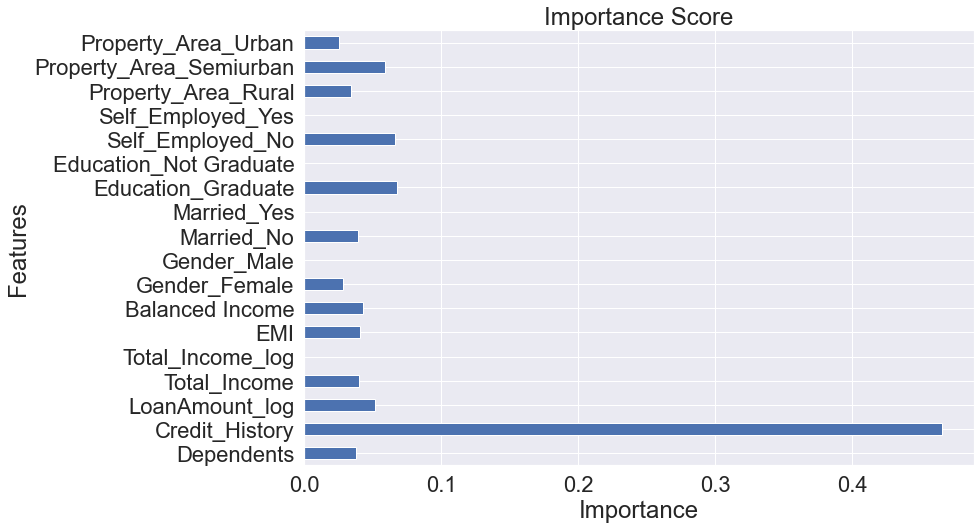

In [184]:
importances=pd.Series(modelXGB.feature_importances_, index=X.columns)
plt.ylabel("Features")
plt.xlabel("Importance")
plt.title("Importance Score")
importances.plot(kind='barh', figsize=(12,8))

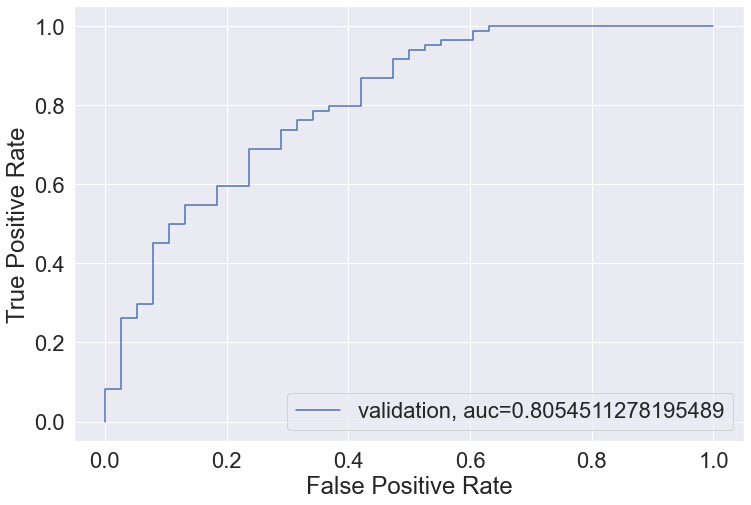

In [185]:
fpr, tpr, _ = metrics.roc_curve(XBG_y, pred_XGB_proba)
auc = metrics.roc_auc_score(XBG_y, pred_XGB_proba)
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [186]:
meandf.loc['XGBoost'] = [meanacc,meanpre,meanrec,auc]

In [187]:
meandf['F1'] = (2*((meandf['Precision']*meandf['Recall'])/(meandf['Precision']+meandf['Recall'])))
meandf

,Accuracy,Precision,Recall,Roc_Auc,F1
LogisticR,0.809463,0.790726,0.983361,0.807331,0.876585
DecisionTree,0.809423,0.790662,0.983417,0.685620,0.876568
RandomTree,0.788245,0.797829,0.926555,0.805451,0.857387
XGBoost,0.762215,0.795797,0.879300,0.805451,0.835467


Metrics for all the models 

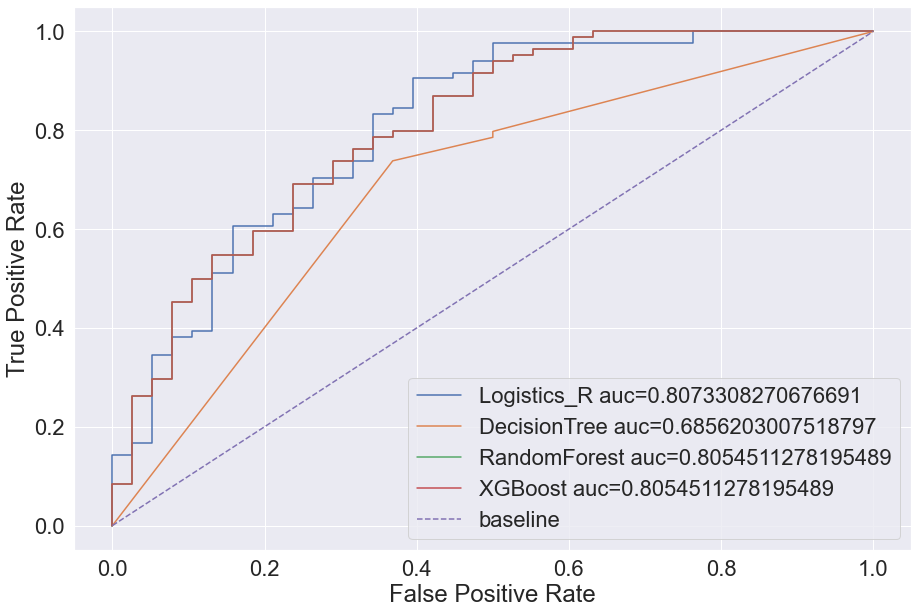

In [188]:
fpr1, tpr1, _ = metrics.roc_curve(LogR_y, pred_proba_LogR)
auc1 = metrics.roc_auc_score(LogR_y, pred_proba_LogR)
fpr2, tpr2, _ = metrics.roc_curve(DecT_y, pred_proba_tree)
auc2 = metrics.roc_auc_score(DecT_y, pred_proba_tree)
fpr3, tpr3, _ = metrics.roc_curve(RanT, pred_proba_random)
auc3 = metrics.roc_auc_score(RanT, pred_proba_random)
fpr4, tpr4, _ = metrics.roc_curve(XBG_y, pred_XGB_proba)
auc4 = metrics.roc_auc_score(XBG_y, pred_XGB_proba)
plt.figure(figsize=(15,10))
plt.plot(fpr1, tpr1, label="Logistics_R auc="+str(auc1))
plt.plot(fpr2, tpr2, label="DecisionTree auc="+str(auc2))
plt.plot(fpr3, tpr3, label="RandomForest auc="+str(auc3))
plt.plot(fpr4, tpr4, label="XGBoost auc="+str(auc4))
plt.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        label='baseline',
        linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

RoC_AuC for all the models